__Summary__
 - загружаем данные из yfinance (пока по одной компании, потом надо будет выбрать несколько) и считаем темп прироста - это 1ая группа фичей
 - загружаем данные из GDELT и вытаскиваем тональность новостей ( потом надо подумать, сколько новостей за день брать (сейчас по умолчанию 250 и как их агрегировать в одно значение - сейчас по среднему и это имхо не очень) - это 2ая группа фичей
 - таргет цена закрытия минус цена открытия на СЛЕДУЮЩИЙ ДЕНЬ и сделать бинарным значени: 0 - падение, 1 - рост, 
 - пробуем gatboost/gxboost/lightgbm/нейронки (LSTM?) 
 - смотрим на интрепретируемость модели (shap)


__что еще не сделала__
- поперебирать гиперпараметры с помощью optuna/hyperopt, сменить подход под grisearch
- добавить вариант с нейронками
- интрепретируемость модели (shap)
- САМОЕ ГЛАВНОЕ - данные порисечить

## Импорт библиотек

In [38]:
import yfinance as yf
from pandas import Series
from gdeltdoc import GdeltDoc, Filters, near, repeat
import pandas as pd
from sklearn.feature_selection import f_classif, mutual_info_classif

from itertools import combinations
from scipy.stats import ttest_ind

# import packages
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# set the aesthetic style of the plots
sns.set_style()

# filter warning messages
import warnings
warnings.filterwarnings('ignore')

## Тест выгрузки данных

### данные по NVIDIA из yfinance

In [2]:
#tickers = yf.download('msft aapl goog', start="2020-01-01", end="2020-12-30")
tickers = yf.Tickers('nvda')

In [25]:
tickers.tickers.NVDA.history(period="1mo")

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-01-04,524.169983,546.099976,518.500000,524.539978,14016000,0,0
2021-01-05,523.989990,537.739990,523.479980,536.190002,8069000,0,0
2021-01-06,528.900024,529.799988,503.440002,504.579987,14510600,0,0
2021-01-07,518.700012,535.109985,515.460022,533.760010,11537000,0,0
2021-01-08,534.500000,536.840027,521.679993,531.070007,7302500,0,0
2021-01-11,536.750000,558.440002,534.500000,544.859985,12975700,0,0
2021-01-12,550.099976,550.179993,533.799988,539.390015,7286900,0,0
2021-01-13,539.599976,545.000000,535.400024,541.270020,5250700,0,0
2021-01-14,543.000000,543.989990,527.219971,528.010010,7078000,0,0


In [26]:
type(tickers.tickers.NVDA.history(period="1mo"))

pandas.core.frame.DataFrame

In [27]:
df_stock = tickers.tickers.NVDA.history(period="1mo")

In [28]:
len(df_stock)

20

#### Считаем таргет 

In [29]:
df_stock['target'] = (df_stock['Close'] - df_stock['Open'])

In [30]:
df_stock['target'] = df_stock['target'].apply(lambda x: 1 if x > 0 else 0)

In [31]:
df_stock.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,target
Date,,,,,,,,
2021-01-04,524.169983,546.099976,518.500000,524.539978,14016000,0,0,1
2021-01-05,523.989990,537.739990,523.479980,536.190002,8069000,0,0,1
2021-01-06,528.900024,529.799988,503.440002,504.579987,14510600,0,0,0
2021-01-07,518.700012,535.109985,515.460022,533.760010,11537000,0,0,1
2021-01-08,534.500000,536.840027,521.679993,531.070007,7302500,0,0,0


In [36]:
df_stock['target_shift'] = df_stock['target'].shift(periods=-1)

In [37]:
df_stock.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,target,target_shift
Date,,,,,,,,,
2021-01-04,524.169983,546.099976,518.500000,524.539978,14016000,0,0,1,NaN
2021-01-05,523.989990,537.739990,523.479980,536.190002,8069000,0,0,1,1.0
2021-01-06,528.900024,529.799988,503.440002,504.579987,14510600,0,0,0,1.0
2021-01-07,518.700012,535.109985,515.460022,533.760010,11537000,0,0,1,0.0
2021-01-08,534.500000,536.840027,521.679993,531.070007,7302500,0,0,0,1.0


#### вытаскиваем новую фичу - темп прироста

In [9]:
df_stock.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'target'],
      dtype='object')

In [11]:
df_stock['growth'] = ((df_stock['Close'] - df_stock['Open'])/df_stock['Open'])*100

In [48]:
df_stock.head(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,target,growth
Date,,,,,,,,,
2020-12-30,519.609985,528.549988,515.869995,525.830017,5634900,0,0,1,1.197058
2020-12-31,525.460022,526.039978,516.599976,522.200012,4806500,0,0,0,-0.620411


In [18]:
df_stock = df_stock.groupby(pd.Grouper(level="Date", freq="1D")).mean(); 
df_stock.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,target,growth
Date,,,,,,,,,
2021-01-04,524.169983,546.099976,518.500000,524.539978,14016000.0,0.0,0.0,1.0,0.070587
2021-01-05,523.989990,537.739990,523.479980,536.190002,8069000.0,0.0,0.0,1.0,2.328291
2021-01-06,528.900024,529.799988,503.440002,504.579987,14510600.0,0.0,0.0,0.0,-4.598230
2021-01-07,518.700012,535.109985,515.460022,533.760010,11537000.0,0.0,0.0,1.0,2.903412
2021-01-08,534.500000,536.840027,521.679993,531.070007,7302500.0,0.0,0.0,0.0,-0.641720


In [19]:
len(df_stock)

29

### данные по NVIDIA из GDELT

In [16]:
features = [
    'nvidia', 'geforce', 'geforce rtx', 'geForce now', 'nvidia rtx', 'nvidia shield', 'nvidia dgx'
]

In [23]:
for ft in features:
    f = Filters(
        start_date = "2021-01-04",
        end_date = "2021-02-01",
        num_records = 250,
        keyword = ft,
    #     domain = ["bbc.co.uk", "nytimes.com", "cnn.com"],
    #     country = ["UK", "US"],
    #     theme = "ECON_STOCKMARKET",

    #     near = near(3, "amazon", "stock"),
    #     repeat = repeat(3, "stock")
    )
    gd = GdeltDoc()
    # Get a timeline of the number of articles matching the filters
    timelinetone = gd.timeline_search("timelinetone", f)
    timelinetone = timelinetone.groupby(pd.Grouper(key="datetime", freq="1D")).mean()
    
    timelinevolraw = gd.timeline_search("timelinevolraw", f)
    timelinevolraw = timelinevolraw.groupby(pd.Grouper(key="datetime", freq="1D")).sum()

    
    df_stock[f'{ft}_av_tone'] = timelinetone['Average Tone'].values
    df_stock[f'{ft}_art_count'] = timelinevolraw['Article Count'].values

In [24]:
df_stock.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,target,growth,nvidia_av_tone,...,geforce rtx_av_tone,geforce rtx_art_count,geForce now_av_tone,geForce now_art_count,nvidia rtx_av_tone,nvidia rtx_art_count,nvidia shield_av_tone,nvidia shield_art_count,nvidia dgx_av_tone,nvidia dgx_art_count
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,524.169983,546.099976,518.500000,524.539978,14016000.0,0.0,0.0,1.0,0.070587,0.4729,...,0.6233,25,-1.3206,7,1.2991,17,-0.9907,2,0.0000,0
2021-01-05,523.989990,537.739990,523.479980,536.190002,8069000.0,0.0,0.0,1.0,2.328291,0.2470,...,0.2027,35,2.0067,1,0.9537,28,-0.1784,1,0.0000,0
2021-01-06,528.900024,529.799988,503.440002,504.579987,14510600.0,0.0,0.0,0.0,-4.598230,0.1515,...,-0.5744,30,-0.6038,6,-1.0641,14,2.0979,1,0.5709,1
2021-01-07,518.700012,535.109985,515.460022,533.760010,11537000.0,0.0,0.0,1.0,2.903412,0.7722,...,0.6361,36,0.7181,6,1.1037,37,2.0052,4,0.0000,0
2021-01-08,534.500000,536.840027,521.679993,531.070007,7302500.0,0.0,0.0,0.0,-0.641720,0.5924,...,0.5712,55,-0.0609,3,1.7188,41,-0.8682,2,0.0000,0


In [21]:
len(df_stock)

29

вот тут надо подумать - просто грохнула Nan, а можно было заменить на значения предыдущего дня/нули

In [62]:
df_stock.dropna(inplace=True)

In [63]:
len(df_stock)

21

## Датасет из функции Саши

In [21]:
data = pd.read_csv('/Users/dariamishina/Documents/Pet projects/CompTech/out1.csv')
data.head(10)               

,Unnamed: 0,Open,High,Low,Close,Adj Close,Volume,per_of_growth,Mid_tone,Sum_count
0,2017-01-03,38.630001,39.080002,38.340000,39.049999,36.148453,9677300.0,1.087233,-0.180050,106
1,2017-01-04,39.060001,39.730000,39.060001,39.360001,36.435421,22644500.0,0.768047,-0.840975,122
2,2017-01-05,39.240002,39.750000,38.980000,39.700001,36.750153,12080100.0,1.172271,-0.881550,119
3,2017-01-06,39.700001,40.990002,39.660000,40.779999,37.749912,14628900.0,2.720398,-0.618025,151
4,2017-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.046625,52
5,2017-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.696075,26
6,2017-01-09,40.790001,41.060001,40.619999,40.740002,37.712887,10992500.0,-0.122577,-1.428850,253
7,2017-01-10,40.810001,41.619999,40.779999,41.290001,38.222012,9256300.0,1.176181,-1.289425,219
8,2017-01-11,41.049999,41.419998,40.490002,41.080002,38.273254,10699400.0,0.073088,-0.778575,202
9,2017-01-12,40.790001,40.790001,40.310001,40.720001,37.937847,8633400.0,-0.171610,-1.006225,253


In [22]:
#Переименуем индексы строк в даты, а столбец Дата удалим вообще
data = data.set_index(pd.DatetimeIndex(data['Unnamed: 0']))
data.drop(['Unnamed: 0'], axis=1, inplace=True)
data.head() 

,Open,High,Low,Close,Adj Close,Volume,per_of_growth,Mid_tone,Sum_count
Unnamed: 0,,,,,,,,,
2017-01-03,38.630001,39.080002,38.340000,39.049999,36.148453,9677300.0,1.087233,-0.180050,106
2017-01-04,39.060001,39.730000,39.060001,39.360001,36.435421,22644500.0,0.768047,-0.840975,122
2017-01-05,39.240002,39.750000,38.980000,39.700001,36.750153,12080100.0,1.172271,-0.881550,119
2017-01-06,39.700001,40.990002,39.660000,40.779999,37.749912,14628900.0,2.720398,-0.618025,151
2017-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.046625,52


__посчитаем таргет__

In [23]:
data['target'] = (data['Close'] - data['Open'])

In [24]:
data['target'] = data['target'].apply(lambda x: 1 if x > 0 else 0)

In [25]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,per_of_growth,Mid_tone,Sum_count,target
Unnamed: 0,,,,,,,,,,
2017-01-03,38.630001,39.080002,38.340000,39.049999,36.148453,9677300.0,1.087233,-0.180050,106,1
2017-01-04,39.060001,39.730000,39.060001,39.360001,36.435421,22644500.0,0.768047,-0.840975,122,1
2017-01-05,39.240002,39.750000,38.980000,39.700001,36.750153,12080100.0,1.172271,-0.881550,119,1
2017-01-06,39.700001,40.990002,39.660000,40.779999,37.749912,14628900.0,2.720398,-0.618025,151,1
2017-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.046625,52,0


In [26]:
#поднимаем вверх на 1, чтобы поднять завтрашнее значение роста/падения
data['target_shift'] = data['target'].shift(periods=-1)

In [27]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,per_of_growth,Mid_tone,Sum_count,target,target_shift
Unnamed: 0,,,,,,,,,,,
2017-01-03,38.630001,39.080002,38.340000,39.049999,36.148453,9677300.0,1.087233,-0.180050,106,1,1.0
2017-01-04,39.060001,39.730000,39.060001,39.360001,36.435421,22644500.0,0.768047,-0.840975,122,1,1.0
2017-01-05,39.240002,39.750000,38.980000,39.700001,36.750153,12080100.0,1.172271,-0.881550,119,1,1.0
2017-01-06,39.700001,40.990002,39.660000,40.779999,37.749912,14628900.0,2.720398,-0.618025,151,1,0.0
2017-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.046625,52,0,0.0


## Скрипт Никиты для загрузки датасета

In [50]:
import yfinance as yf
import pandas as pd
from gdeltdoc import Filters, GdeltDoc
import re


def get_data_yfinance(quotation: str, start_date: str, end_date: str, interval='1d') -> pd.DataFrame:
    """Взять данные с yahoo finance
    params:
      quotation: название котировки, данные для которой хотим получить
      start_date, end_date - интервал, формат "год-месяц-день"
      interval - периодичность, формат "(номер)(первая буква слова (d, m, y))"
    returns:
      DataFrame формата "Тикет, Время, 6 видов цен"
    """
    df_res = yf.download(tickers=quotation,
                         start=start_date,
                         end=end_date,
                         interval=interval)
    df_res.loc[:, 'Ticker'] = quotation
    df_res = df_res.groupby(pd.Grouper(level="Date", freq=interval.upper())).mean()
    # Приводим время к одному виду для слияния
    df_res.index = pd.to_datetime(df_res.index).tz_localize('Etc/UCT')
    return df_res


def get_data_gdelt(quotation: str, keywords: list, start_date: str, end_date: str, interval="1d", num_records=250,
                   repeats=3) -> pd.DataFrame:
    """Взять данные с gdelt
    params:
      quotation - имя ценной бумаги
      keywords - из графа знаний по ключевому слову
      start_date, end_date - интервал, формат "год-месяц-день"
      interval - периодичность, формат "(номер)(первая буква слова (d, m, y))"
      num_records - сколько максимум записей взять за промежуток
      (не реализовано) repeats - сколько раз должно повториться ключевое слово в статье
    returns:
      DataFrame формата "Datetime (индекс), Ticker,
        [Average_Tone, Article_Count, Volume_Intensity]_[std, mean, sum, min, max]"
      Ticker и есть ключевое слово
    """

    df_res = None
    df_dub = pd.DataFrame()
    # Как называются колонки в полученных DataFrames
    col_names = ['Average_Tone', 'Article_Count', 'Volume_Intensity']

    # Что будем искать для данных ключевых слов
    # Тон статей, их количество и их кол-во в отношении ко всем остальным
    match_list = ["timelinetone", "timelinevolraw", "timelinevol"]
    match_dict = dict(zip(match_list, col_names))
    for ft in keywords:
        f = Filters(
            start_date=start_date,
            end_date=end_date,
            num_records=num_records,
            keyword=ft
        )

        gd = GdeltDoc()
        # Get a timeline of the number of articles matching the filters
        for timeline in match_list:
            timeline_data = gd.timeline_search(timeline, f)
            timeline_data = timeline_data.fillna(0)
            timeline_data = timeline_data.groupby(pd.Grouper(key="datetime", freq=interval.upper()))
            if timeline in ['timelinetone']:
                timeline_data = timeline_data.mean()
            else:
                timeline_data = timeline_data.sum()

            # Собираем все фичи в один датафрейм, далее их разделим
            col_name = match_dict[timeline]
            df_dub[f"{ft}_{timeline}_{col_name}"] = timeline_data[col_name.replace('_', ' ')].values

            # Так как мы копируем только колонки, то надо один раз откопировать дату в итог
            if df_res is None:
                # Так же выровняем индексы, чтобы при копировании не выдавалось NaN
                df_res = pd.DataFrame(index=timeline_data.index)
                df_dub.index = timeline_data.index

    # Нужно создать колонки со средним, средним отклонением, минимумом и максимумом для каждой фичи
    # Для начала нужно найти все колонки, для которых будем это считать
    columns = df_dub.columns

    # Сначала сформируем список датафреймов, которые нам нужно достать для каждой колонки
    for pattern in col_names:
        pattern_list = list()
        for col in columns:
            if pattern in col:
                pattern_list.append(col)

        # Теперь для pattern у нас есть список
        # Посчитаем для неё std, mean, min, max, sum
        df_res[f'{pattern}_min'] = df_dub[pattern_list].min(axis=1, skipna=True)
        df_res[f'{pattern}_max'] = df_dub[pattern_list].max(axis=1, skipna=True)
        df_res[f'{pattern}_mean'] = df_dub[pattern_list].mean(axis=1, skipna=True)
        df_res[f'{pattern}_std'] = df_dub[pattern_list].std(axis=1, skipna=True)
        df_res[f'{pattern}_sum'] = df_dub[pattern_list].sum(axis=1, skipna=True)

    df_res.loc[:, 'Ticker'] = quotation
    return df_res


def get_dataframe(**kwargs) -> pd.DataFrame:
    """ Получить полный датафрейм с источников
        params:
          quotation - имя ценной бумаги
          keywords - из графа знаний по ключевому слову
          start_date, end_date - интервал, формат "год-месяц-день"
          interval - периодичность, формат "(номер)(первая буква слова (d, m, y))"
          num_records - сколько максимум записей взять за промежуток
          (не реализовано) repeats - сколько раз должно повториться ключевое слово в статье
        returns:
          DataFrame формата "Datetime (индекс), Ticker,
            [Average_Tone, Article_Count, Volume_Intensity]_[std, mean, sum, min, max], - из новостей
            Open, High, Low, Close, Adj Close, Volume - из финансов
    """
#     pattern = re.compile('^(19|20)\d\d[-](0[1-9]|1[012])[-](0[1-9]|[12][0-9]|3[01])$')
#     assert pattern.match(kwargs['start_date']) is None, "Дата старта в правильном формате имеет вид (гггг-мм-дд)"
#     assert pattern.match(kwargs['end_date']) is None, "Дата конца в правильном формате имеет вид (гггг-мм-дд)"

    gdelt_data = get_data_gdelt(**kwargs)
    yfinance_data = get_data_yfinance(quotation=kwargs['quotation'],
                                      start_date=kwargs['start_date'],
                                      end_date=kwargs['end_date'],
                                      interval="1d" if not kwargs.get('interval') else kwargs['interval'])
    res = pd.concat([gdelt_data, yfinance_data], axis=1)
    del gdelt_data
    del yfinance_data
    return res

In [52]:
def prepare_train_samp(quotation_tr: str, keywords_tr: list, start_date_tr: str, end_date_tr: str,
                   features: list, size_window: int, days_forward: int) -> pd.DataFrame:
    #size_window - размер скользяцего окна
    #check - через сколько дней хотим проверить
    #features(названия брать из get_dataframe) - лист признаков которые нужны в итоге
    
    
    df = get_dataframe(quotation=quotation_tr, keywords=keywords_tr,start_date= start_date_tr, end_date=end_date_tr, interval="1d", num_records=250)
    #Выбираем тоьлко интересующие нас признаки
    df = df[features]
    
    #Дропаем наны
    df = df.dropna() 
    
    #df.query("Ticker == 'quotation_tr'").iloc[-size_window:-1].Open.to_list() + ['quotation_tr']
#     df.query("Ticker == 'quotation_tr'").iloc[-1].Open
    features.remove('Ticker')
    #Пробегаем по всем признакам
    for sign in features:
    #Смотрим предыдущие значения и слепляем их в наш Dataframe по тикету
        out = []
        for name in df.Ticker.unique():
            tmp = df.loc[df.query(f'Ticker == "{name}"').index]
            for i in range(-size_window, 0):
                column = f'{sign}_pr{i}'
                tmp[column] = tmp[f'{sign}'].shift(-i)
            out.append(tmp)
            df = pd.concat(out)
            
            
    df.loc[:, 'target'] = (df['Open'] - df['Open'].shift(periods=-days_forward))
    df.loc[:, 'target'] = df['target'].apply(lambda x: 1 if x < 0 else 0)
    #Дропаем наны которые появились из-за окна
    df.dropna(inplace=True)
    return df    


In [53]:
#Пример вызова
df = prepare_train_samp(quotation_tr='MSFT', keywords_tr=['microsoft'],
                        start_date_tr= '2017-01-01', end_date_tr='2021-01-10',
                        features =['Ticker', 'High', 'Open', 'Close', 'Average_Tone_sum'], 
                        size_window=3, days_forward=1)

[*********************100%***********************]  1 of 1 completed


In [54]:
df.head()

,Ticker,High,Open,Close,Average_Tone_sum,High_pr-3,High_pr-2,High_pr-1,Open_pr-3,Open_pr-2,Open_pr-1,Close_pr-3,Close_pr-2,Close_pr-1,Average_Tone_sum_pr-3,Average_Tone_sum_pr-2,Average_Tone_sum_pr-1,target
2017-01-06 00:00:00+00:00,MSFT,63.150002,62.299999,62.840000,0.8981,62.840000,62.750000,62.660000,62.790001,62.480000,62.189999,62.580002,62.299999,62.299999,0.5453,1.0115,1.2107,1
2017-01-09 00:00:00+00:00,MSFT,63.080002,62.759998,62.639999,0.9374,62.750000,62.660000,63.150002,62.480000,62.189999,62.299999,62.299999,62.299999,62.840000,1.0115,1.2107,0.8981,0
2017-01-10 00:00:00+00:00,MSFT,63.070000,62.730000,62.619999,0.8288,62.660000,63.150002,63.080002,62.189999,62.299999,62.759998,62.299999,62.840000,62.639999,1.2107,0.8981,0.9374,0
2017-01-11 00:00:00+00:00,MSFT,63.230000,62.610001,63.189999,-0.1810,63.150002,63.080002,63.070000,62.299999,62.759998,62.730000,62.840000,62.639999,62.619999,0.8981,0.9374,0.8288,1
2017-01-12 00:00:00+00:00,MSFT,63.400002,63.060001,62.610001,0.4675,63.080002,63.070000,63.230000,62.759998,62.730000,62.610001,62.639999,62.619999,63.189999,0.9374,0.8288,-0.1810,0


In [55]:
data = df.drop(['Ticker'], axis=1)
data.head() 

,High,Open,Close,Average_Tone_sum,High_pr-3,High_pr-2,High_pr-1,Open_pr-3,Open_pr-2,Open_pr-1,Close_pr-3,Close_pr-2,Close_pr-1,Average_Tone_sum_pr-3,Average_Tone_sum_pr-2,Average_Tone_sum_pr-1,target
2017-01-06 00:00:00+00:00,63.150002,62.299999,62.840000,0.8981,62.840000,62.750000,62.660000,62.790001,62.480000,62.189999,62.580002,62.299999,62.299999,0.5453,1.0115,1.2107,1
2017-01-09 00:00:00+00:00,63.080002,62.759998,62.639999,0.9374,62.750000,62.660000,63.150002,62.480000,62.189999,62.299999,62.299999,62.299999,62.840000,1.0115,1.2107,0.8981,0
2017-01-10 00:00:00+00:00,63.070000,62.730000,62.619999,0.8288,62.660000,63.150002,63.080002,62.189999,62.299999,62.759998,62.299999,62.840000,62.639999,1.2107,0.8981,0.9374,0
2017-01-11 00:00:00+00:00,63.230000,62.610001,63.189999,-0.1810,63.150002,63.080002,63.070000,62.299999,62.759998,62.730000,62.840000,62.639999,62.619999,0.8981,0.9374,0.8288,1
2017-01-12 00:00:00+00:00,63.400002,63.060001,62.610001,0.4675,63.080002,63.070000,63.230000,62.759998,62.730000,62.610001,62.639999,62.619999,63.189999,0.9374,0.8288,-0.1810,0


## EDA

__Вводная от Валентина__
Пока Никита делает важную работу по написанию метода (если что помогите ему с этим), предлагаю остальным взглянуть на данные — построить графики зависимостей, попробовать пошевелить данные и заняться ресерчем (к примеру, сегодня Саша выяснил что тональность не всегда отражает зависимости роста акций, а важно еще количество новостей)

Для начала: 
Воспользуемся методом Артема
https://github.com/comptech-winter-school/stock-news/blob/Karasyuk/data_preprocess/get_data.py
 УДАЛИМ ОТТУДА НАНЫ (если в этом не уверены)

А также посмотрим на данные 
[stock-news/stocks.json at main · comptech-winter-school/stock-news · GitHub](https://github.com/comptech-winter-school/stock-news/blob/main/additional/stocks.json)

Ну и построим графики корреляций, построим плотности распределений графиков, давайте визуализируем интересные зависимости. 

Советую внедрить проценты рост относительно прошлого дня (формула: (i день - (i-1) день)/(i-1) день )

Достаточно интересным является то, что в файле с акциями все разбито на сектора. Давайте проверим теорию отдельных моделей относительно сектора? Сделаем выборку по каждой из категории и посмотрим на данные.

Бейзлайн будем выкатывать уже позже (нужен метод обработки данных)

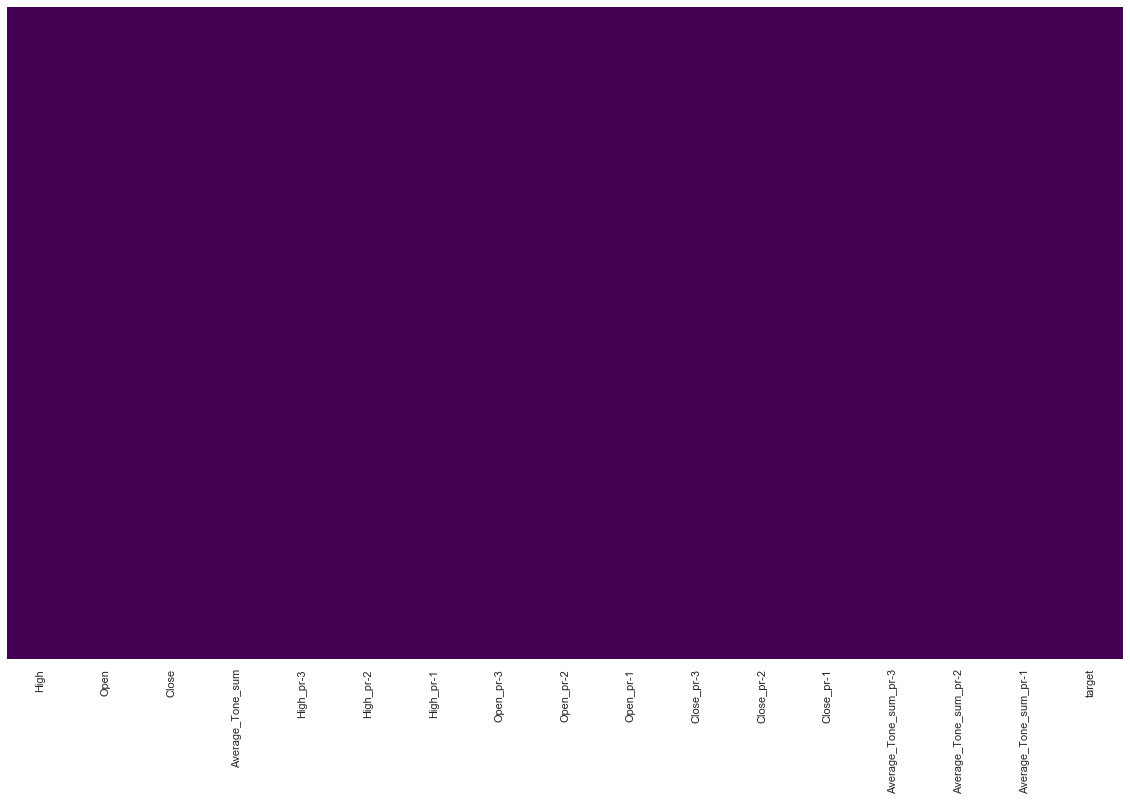

In [56]:
#посмотрим, что у нас с пропусками
fig, ax = plt.subplots(figsize=(20, 12))
sns_heatmap = sns.heatmap(
    data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [29]:
#удаляем Наны
data.dropna(inplace=True)

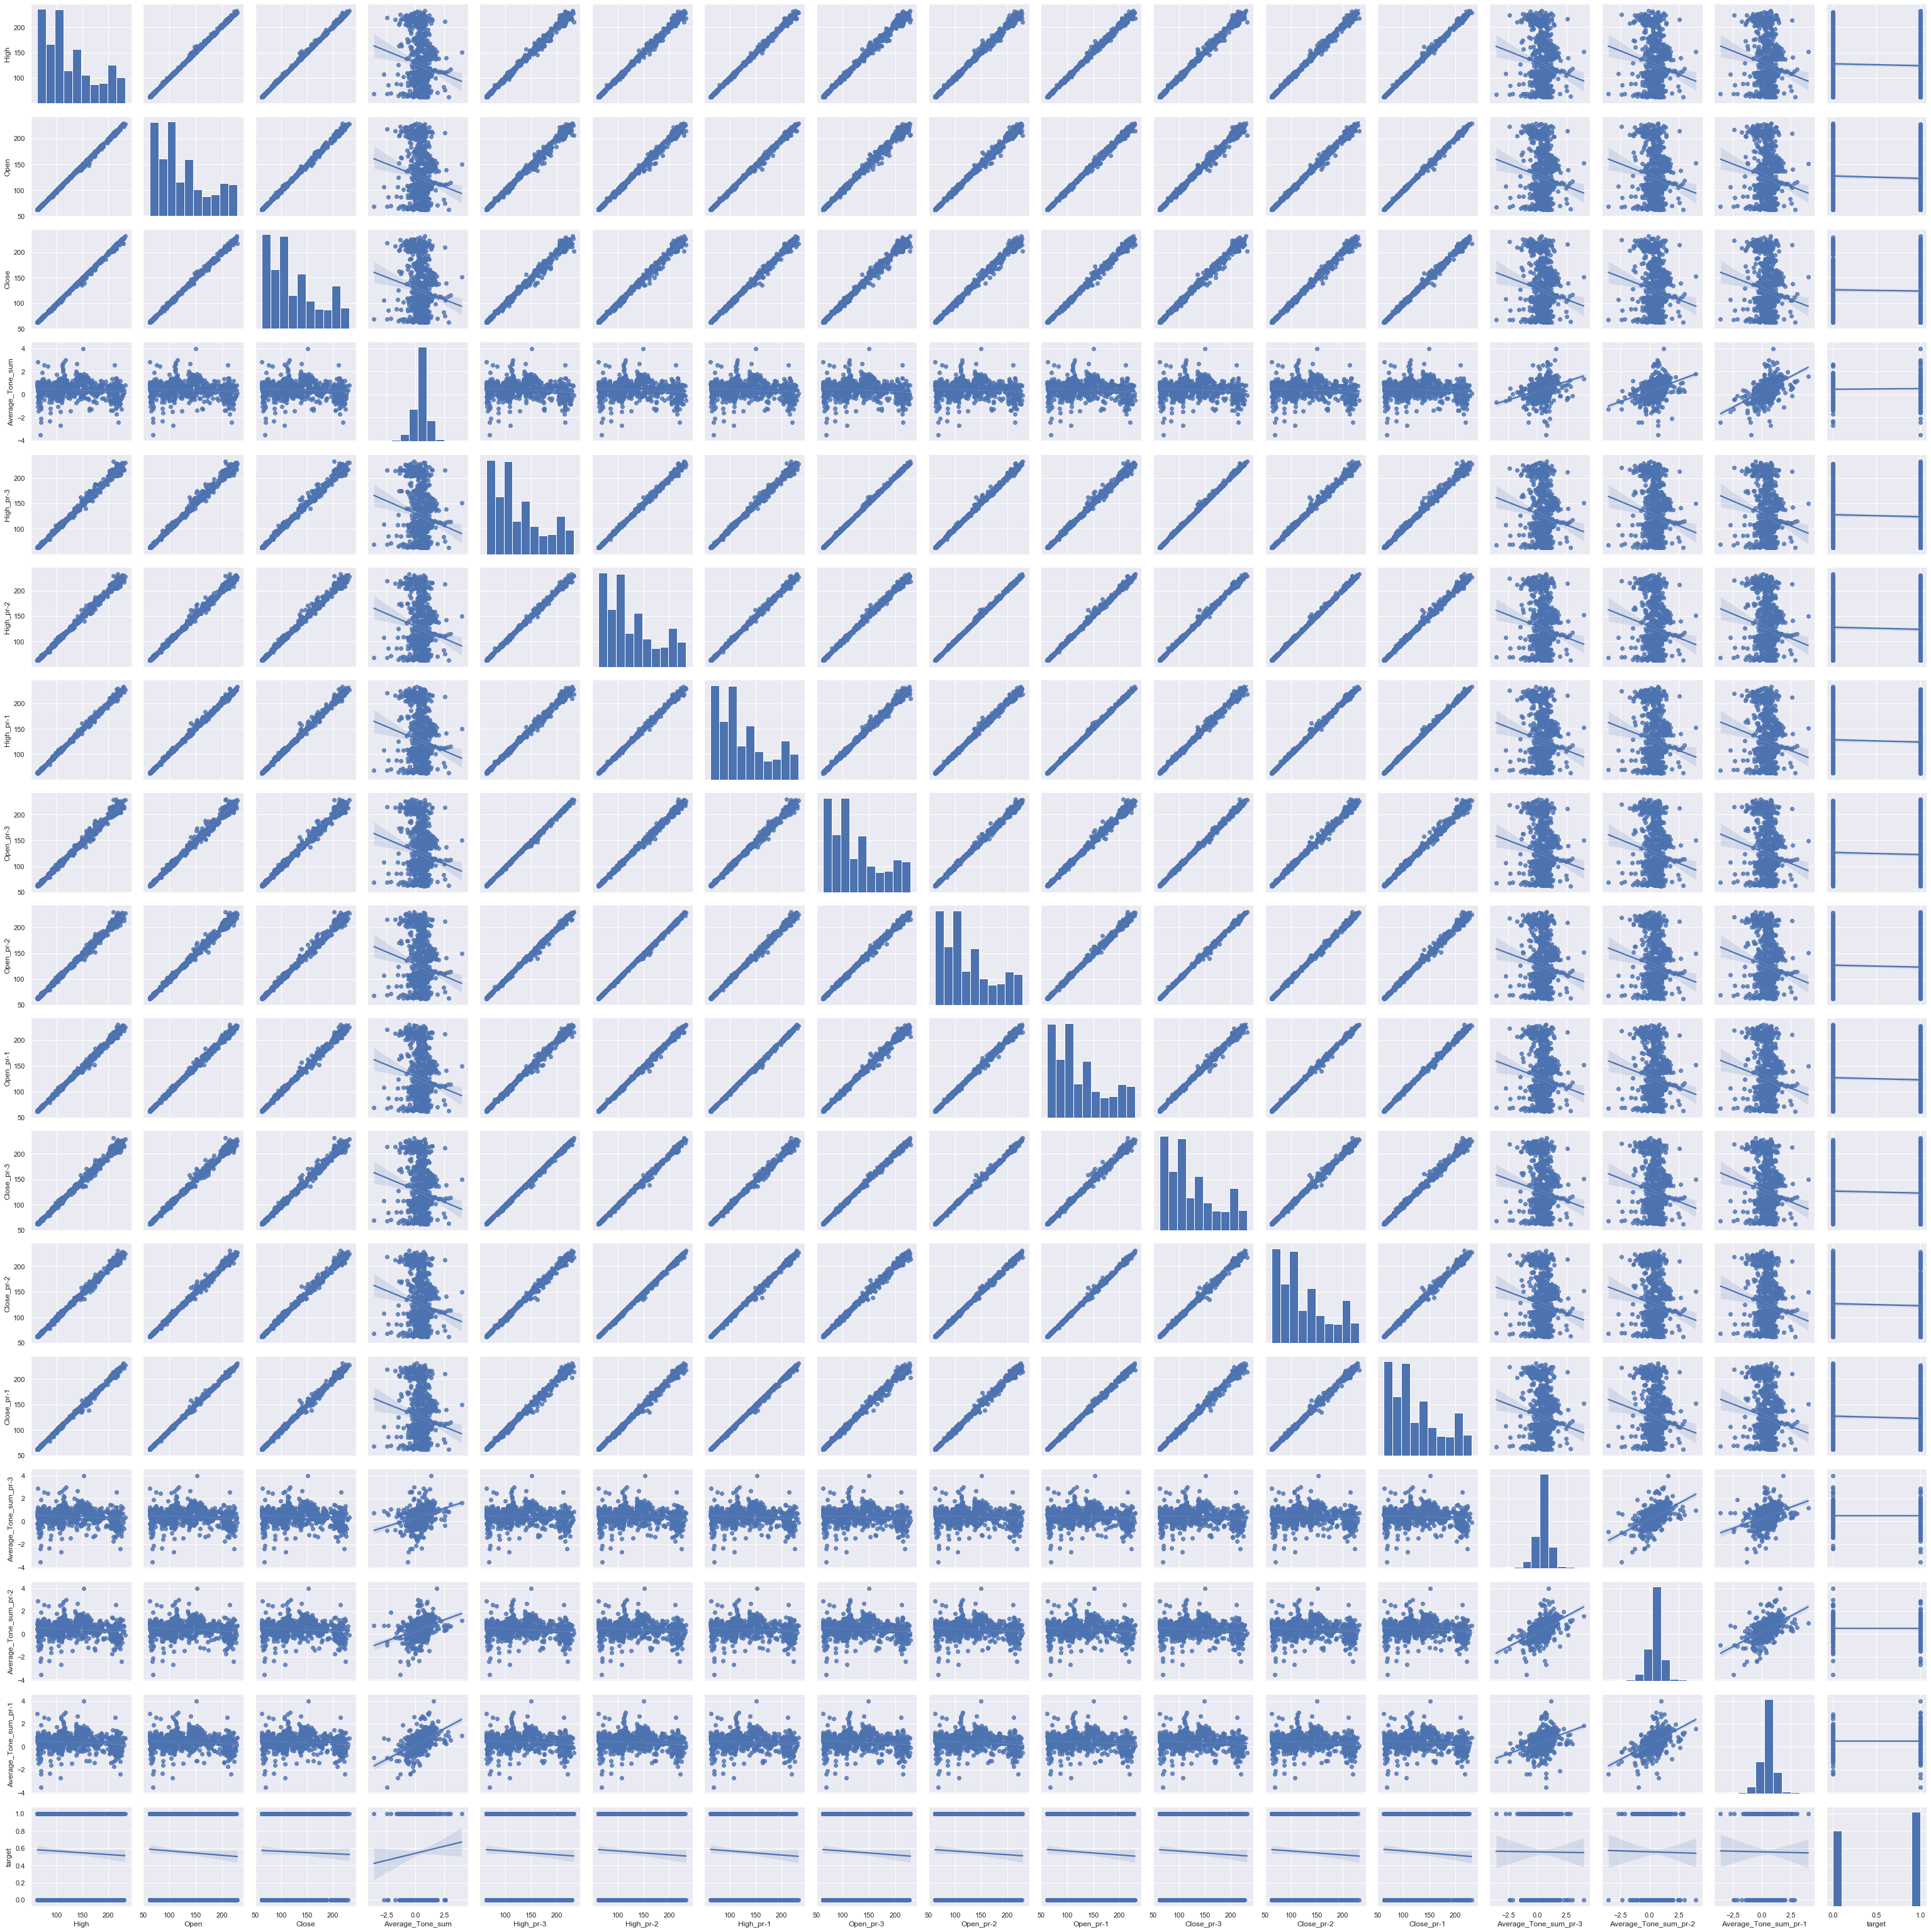

In [57]:
#Для быстрого построения графиков зависимости переменных можно воспользоваться функцией pairplot из модуля seaborn:
sns.pairplot(data, kind = 'reg')

In [58]:
data.corr()

,High,Open,Close,Average_Tone_sum,High_pr-3,High_pr-2,High_pr-1,Open_pr-3,Open_pr-2,Open_pr-1,Close_pr-3,Close_pr-2,Close_pr-1,Average_Tone_sum_pr-3,Average_Tone_sum_pr-2,Average_Tone_sum_pr-1,target
High,1.000000,0.999592,0.999483,-0.124040,0.997307,0.998094,0.999066,0.996935,0.997715,0.998504,0.997389,0.998151,0.999130,-0.120771,-0.122942,-0.122579,-0.038864
Open,0.999592,1.000000,0.999144,-0.120763,0.996807,0.997731,0.998988,0.996686,0.997506,0.998644,0.997104,0.998070,0.999413,-0.117186,-0.118570,-0.117902,-0.048510
Close,0.999483,0.999144,1.000000,-0.119479,0.996473,0.997355,0.998224,0.996249,0.997218,0.997973,0.996749,0.997707,0.998374,-0.117509,-0.119668,-0.119703,-0.026323
Average_Tone_sum,-0.124040,-0.120763,-0.119479,1.000000,-0.133567,-0.131777,-0.128965,-0.131552,-0.127816,-0.125119,-0.129375,-0.127729,-0.123677,0.321059,0.371796,0.538196,0.042457
High_pr-3,0.997307,0.996807,0.996473,-0.133567,1.000000,0.999063,0.998093,0.999592,0.998985,0.997730,0.999482,0.998222,0.997355,-0.119517,-0.127265,-0.131332,-0.041740
High_pr-2,0.998094,0.997731,0.997355,-0.131777,0.999063,1.000000,0.999064,0.998505,0.999592,0.998987,0.999131,0.999482,0.998222,-0.118462,-0.122260,-0.128476,-0.042610
High_pr-1,0.999066,0.998988,0.998224,-0.128965,0.998093,0.999064,1.000000,0.997717,0.998504,0.999591,0.998153,0.999128,0.999483,-0.120093,-0.121285,-0.123533,-0.046018
Open_pr-3,0.996935,0.996686,0.996249,-0.131552,0.999592,0.998505,0.997717,1.000000,0.998644,0.997509,0.999143,0.997979,0.997223,-0.116333,-0.123495,-0.127394,-0.043768
Open_pr-2,0.997715,0.997506,0.997218,-0.127816,0.998985,0.999592,0.998504,0.998644,1.000000,0.998645,0.999411,0.999145,0.997975,-0.113838,-0.119027,-0.124673,-0.040095
Open_pr-1,0.998504,0.998644,0.997973,-0.125119,0.997730,0.998987,0.999591,0.997509,0.998645,1.000000,0.998074,0.999412,0.999142,-0.115691,-0.116588,-0.120243,-0.043928


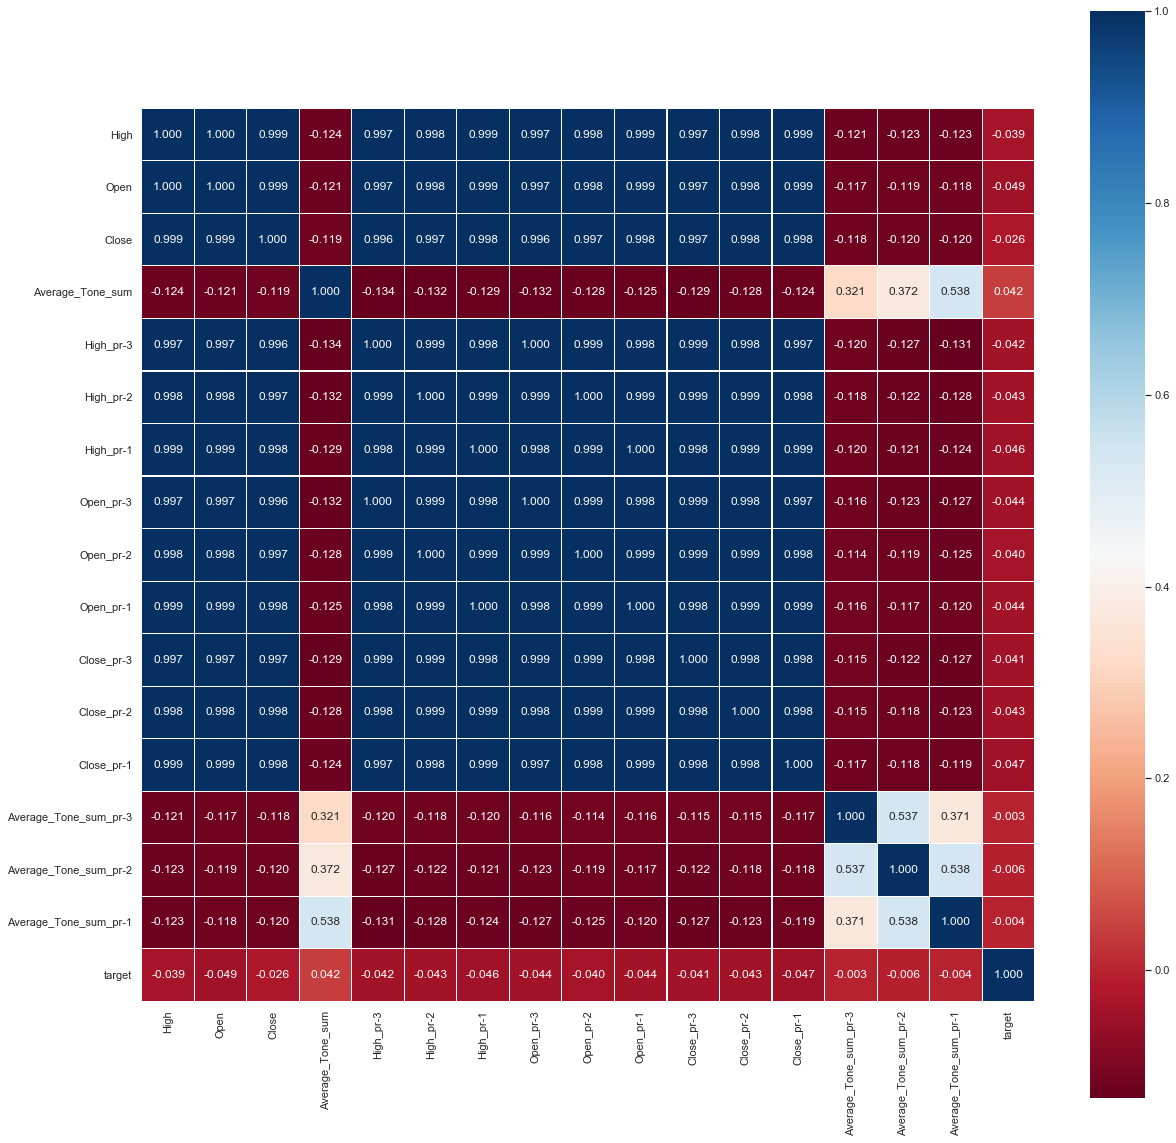

In [59]:
#Используем для наглядности матрицу корреляций:
#строим тепловую карту 
sns.set(font_scale=1)
plt.subplots(figsize=(20, 20))
sns.heatmap(data.corr(), square=True,
              annot=True, fmt=".3f", linewidths=0.1, cmap="RdBu")

Для корреляции есть пороги вроде: <0.3 слабая, 0.3-0.7 умеренная, >0.7 сильная.

Не стоит доверять корреляционному анализу слепо и выкидывать признаки из модели. Нельзя ни в коем случае смотреть на то, как скоррелированы признаки и целевая переменная: если сильно коррелирует, то признак значимый - оставляем, если слабо - удаляем. Вы не можете просто так удалять данные, если коэфициент корреляции низкий. Если признак1 влияет в два раза слабее, чем признак2 это не повод выбрасывать признак1, он все равно значимый для модели. Для определения этого и существует t-test, и основанная на нем p-value для тестирования нулевой гипотезы, что признак1 не является значимым. 

Есть сильно скоррелированные параметры, но поскольку модель у нас уже выбрана?( и это разные варианты бустинга) то удалять ничего не будем, так как для бустинга мультиколлинеарность не проблема, как и не проблема распределение, не являющееся нормальным

In [62]:
#добавила параметр nan_policy='omit'
def get_stat_dif(column):
        # На входе имеем имя столбца с данными
    # Проверяем характер распределения оценок в зависимости от значений в этом столбце
    cols = data.loc[:, column].value_counts().index
    # Создаём все возможные парные комбинации из элементов списка cols 
    combinations_all = list(combinations(cols, 2))
    # Для каждой пары номинативных значений рассматриваемого столбца
    # выполняем тест Стьюдента с поправкой Бонферони
    for comb in combinations_all:
        # Готовим аргументы для функции ttest_ind()
        if ttest_ind(data.loc[data.loc[:, column] == comb[0], 'target'], 
                        data.loc[data.loc[:, column] == comb[1], 'target'], nan_policy='omit').pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [63]:
for col in data.columns:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки High
Найдены статистически значимые различия для колонки Open
Найдены статистически значимые различия для колонки Close
Найдены статистически значимые различия для колонки Average_Tone_sum
Найдены статистически значимые различия для колонки High_pr-3
Найдены статистически значимые различия для колонки High_pr-2
Найдены статистически значимые различия для колонки High_pr-1
Найдены статистически значимые различия для колонки Open_pr-3
Найдены статистически значимые различия для колонки Open_pr-2
Найдены статистически значимые различия для колонки Open_pr-1
Найдены статистически значимые различия для колонки Close_pr-3
Найдены статистически значимые различия для колонки Close_pr-2
Найдены статистически значимые различия для колонки Close_pr-1
Найдены статистически значимые различия для колонки Average_Tone_sum_pr-3
Найдены статистически значимые различия для колонки Average_Tone_sum_pr-2
Найдены статистически значимые различия для колонк

Для оценки значимости числовых переменных будем использовать функцию f_classif из библиотеки sklearn.

Возможности модуля sklearn.feature_selection могут быть использованы не только для выбора важных признаков, но и для уменьшения размерности, улучшения предсказательной силы моделей, либо для повышения их производительности на очень многомерных наборах данных.

В основе метода оценки значимости переменных лежит однофакторный дисперсионный анализ (ANOVA). Основу процедуры составляет обобщение результатов двух выборочных t-тестов для независимых выборок (2-sample t).

В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.

In [67]:
num_cols = data.columns[:-2]
num_cols 

Index(['High', 'Open', 'Close', 'Average_Tone_sum', 'High_pr-3', 'High_pr-2',
       'High_pr-1', 'Open_pr-3', 'Open_pr-2', 'Open_pr-1', 'Close_pr-3',
       'Close_pr-2', 'Close_pr-1', 'Average_Tone_sum_pr-3',
       'Average_Tone_sum_pr-2'],
      dtype='object')

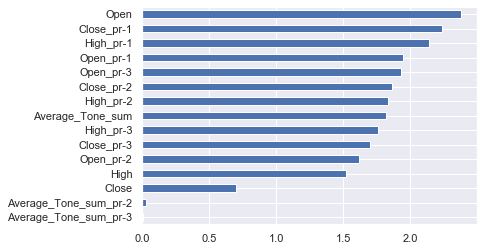

In [68]:
#df[num_cols] - это признаки
#df['target_shift'] - это таргет 
#index = num_cols - а так присваиваются названия признакам, но это именно для сериз
#указываем индекс [0], чтобы выводились значения
imp_num = Series(f_classif(data[num_cols], data['target'])[0], index = num_cols)
#сортировка по убыванию
imp_num.sort_values(inplace = True)
#barh - для переворачивания гистограммы
imp_num.plot(kind = 'barh')

## Модели

In [70]:
# feature matrix
X = data.drop('target', axis=1)
#X = data.drop('target_shift', axis=1)

# target vector
y = data['target']
#y = data['target_shift']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43)


In [71]:
# standardize numerical variables
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# resample
#rus = RandomUnderSampler()
#X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)

In [72]:
# define the function val_model
def val_model(X, y, clf, show=True):
    """
    Apply cross-validation on the training set.

    # Arguments
        X: DataFrame containing the independent variables.
        y: Series containing the target vector.
        clf: Scikit-learn estimator instance.
        
    # Returns
        float, mean value of the cross-validation scores.
    """
    
    X = np.array(X)
    y = np.array(y)

    pipeline = make_pipeline(StandardScaler(), clf)
    scores = cross_val_score(pipeline, X, y, scoring='recall')

    if show == True:
        print(f'Recall: {scores.mean()}, {scores.std()}')
    
    return scores.mean()

In [73]:
#evaluate the models
xgb = XGBClassifier()
lgb = LGBMClassifier()
cb = CatBoostClassifier()

model = []
recall = []

for clf in (xgb, lgb, cb):
    model.append(clf.__class__.__name__)
    recall.append(val_model(X_train, y_train, clf, show=False))

pd.DataFrame(data=recall, index=model, columns=['Recall'])

Learning rate set to 0.008307
0:	learn: 0.6926004	total: 57.1ms	remaining: 57s
1:	learn: 0.6924050	total: 58.6ms	remaining: 29.2s
2:	learn: 0.6920441	total: 60.2ms	remaining: 20s
3:	learn: 0.6915475	total: 62.2ms	remaining: 15.5s
4:	learn: 0.6909612	total: 63.7ms	remaining: 12.7s
5:	learn: 0.6906981	total: 65.9ms	remaining: 10.9s
6:	learn: 0.6899261	total: 67.5ms	remaining: 9.57s
7:	learn: 0.6895180	total: 69.3ms	remaining: 8.59s
8:	learn: 0.6890397	total: 70.9ms	remaining: 7.81s
9:	learn: 0.6885825	total: 72.5ms	remaining: 7.18s
10:	learn: 0.6880442	total: 74.4ms	remaining: 6.69s
11:	learn: 0.6876052	total: 76ms	remaining: 6.25s
12:	learn: 0.6871509	total: 77.5ms	remaining: 5.88s
13:	learn: 0.6866100	total: 79.4ms	remaining: 5.59s
14:	learn: 0.6863327	total: 81ms	remaining: 5.32s
15:	learn: 0.6856585	total: 82.8ms	remaining: 5.09s
16:	learn: 0.6853861	total: 85.1ms	remaining: 4.92s
17:	learn: 0.6849825	total: 86.7ms	remaining: 4.73s
18:	learn: 0.6846898	total: 88.2ms	remaining: 4.55s


161:	learn: 0.6328871	total: 356ms	remaining: 1.84s
162:	learn: 0.6326946	total: 359ms	remaining: 1.84s
163:	learn: 0.6325788	total: 361ms	remaining: 1.84s
164:	learn: 0.6324273	total: 364ms	remaining: 1.84s
165:	learn: 0.6322449	total: 366ms	remaining: 1.84s
166:	learn: 0.6319333	total: 368ms	remaining: 1.84s
167:	learn: 0.6317178	total: 371ms	remaining: 1.83s
168:	learn: 0.6313984	total: 373ms	remaining: 1.83s
169:	learn: 0.6308822	total: 375ms	remaining: 1.83s
170:	learn: 0.6306658	total: 377ms	remaining: 1.82s
171:	learn: 0.6305402	total: 379ms	remaining: 1.82s
172:	learn: 0.6303459	total: 381ms	remaining: 1.82s
173:	learn: 0.6301640	total: 383ms	remaining: 1.82s
174:	learn: 0.6296660	total: 386ms	remaining: 1.82s
175:	learn: 0.6294227	total: 387ms	remaining: 1.81s
176:	learn: 0.6292465	total: 390ms	remaining: 1.81s
177:	learn: 0.6289723	total: 392ms	remaining: 1.81s
178:	learn: 0.6285815	total: 395ms	remaining: 1.81s
179:	learn: 0.6282084	total: 397ms	remaining: 1.81s
180:	learn: 

331:	learn: 0.5872407	total: 715ms	remaining: 1.44s
332:	learn: 0.5869842	total: 717ms	remaining: 1.44s
333:	learn: 0.5867705	total: 719ms	remaining: 1.43s
334:	learn: 0.5865594	total: 721ms	remaining: 1.43s
335:	learn: 0.5864978	total: 723ms	remaining: 1.43s
336:	learn: 0.5863144	total: 726ms	remaining: 1.43s
337:	learn: 0.5859052	total: 728ms	remaining: 1.43s
338:	learn: 0.5856236	total: 730ms	remaining: 1.42s
339:	learn: 0.5854603	total: 732ms	remaining: 1.42s
340:	learn: 0.5851680	total: 735ms	remaining: 1.42s
341:	learn: 0.5849029	total: 738ms	remaining: 1.42s
342:	learn: 0.5846421	total: 740ms	remaining: 1.42s
343:	learn: 0.5844138	total: 742ms	remaining: 1.41s
344:	learn: 0.5841550	total: 744ms	remaining: 1.41s
345:	learn: 0.5839860	total: 747ms	remaining: 1.41s
346:	learn: 0.5839289	total: 748ms	remaining: 1.41s
347:	learn: 0.5837406	total: 750ms	remaining: 1.41s
348:	learn: 0.5836238	total: 752ms	remaining: 1.4s
349:	learn: 0.5832767	total: 755ms	remaining: 1.4s
350:	learn: 0.

501:	learn: 0.5480000	total: 1.07s	remaining: 1.06s
502:	learn: 0.5478128	total: 1.07s	remaining: 1.06s
503:	learn: 0.5476892	total: 1.07s	remaining: 1.06s
504:	learn: 0.5475387	total: 1.08s	remaining: 1.06s
505:	learn: 0.5474495	total: 1.08s	remaining: 1.05s
506:	learn: 0.5472751	total: 1.08s	remaining: 1.05s
507:	learn: 0.5470847	total: 1.08s	remaining: 1.05s
508:	learn: 0.5468333	total: 1.09s	remaining: 1.05s
509:	learn: 0.5465979	total: 1.09s	remaining: 1.05s
510:	learn: 0.5464848	total: 1.09s	remaining: 1.04s
511:	learn: 0.5462842	total: 1.09s	remaining: 1.04s
512:	learn: 0.5461776	total: 1.1s	remaining: 1.04s
513:	learn: 0.5458822	total: 1.1s	remaining: 1.04s
514:	learn: 0.5456932	total: 1.1s	remaining: 1.04s
515:	learn: 0.5454891	total: 1.1s	remaining: 1.03s
516:	learn: 0.5452629	total: 1.1s	remaining: 1.03s
517:	learn: 0.5450034	total: 1.11s	remaining: 1.03s
518:	learn: 0.5449261	total: 1.11s	remaining: 1.03s
519:	learn: 0.5446211	total: 1.11s	remaining: 1.03s
520:	learn: 0.544

675:	learn: 0.5136908	total: 1.42s	remaining: 682ms
676:	learn: 0.5134415	total: 1.42s	remaining: 679ms
677:	learn: 0.5131754	total: 1.43s	remaining: 678ms
678:	learn: 0.5130310	total: 1.43s	remaining: 676ms
679:	learn: 0.5128618	total: 1.43s	remaining: 674ms
680:	learn: 0.5127873	total: 1.43s	remaining: 672ms
681:	learn: 0.5124870	total: 1.44s	remaining: 670ms
682:	learn: 0.5121898	total: 1.44s	remaining: 668ms
683:	learn: 0.5120249	total: 1.44s	remaining: 666ms
684:	learn: 0.5119255	total: 1.44s	remaining: 664ms
685:	learn: 0.5118044	total: 1.45s	remaining: 662ms
686:	learn: 0.5114514	total: 1.45s	remaining: 660ms
687:	learn: 0.5112905	total: 1.45s	remaining: 658ms
688:	learn: 0.5110237	total: 1.45s	remaining: 655ms
689:	learn: 0.5108510	total: 1.45s	remaining: 653ms
690:	learn: 0.5107604	total: 1.46s	remaining: 651ms
691:	learn: 0.5105245	total: 1.46s	remaining: 649ms
692:	learn: 0.5101927	total: 1.46s	remaining: 646ms
693:	learn: 0.5100198	total: 1.46s	remaining: 644ms
694:	learn: 

908:	learn: 0.4658300	total: 1.96s	remaining: 196ms
909:	learn: 0.4655722	total: 1.96s	remaining: 194ms
910:	learn: 0.4654182	total: 1.96s	remaining: 192ms
911:	learn: 0.4652891	total: 1.97s	remaining: 190ms
912:	learn: 0.4651056	total: 1.97s	remaining: 188ms
913:	learn: 0.4650412	total: 1.97s	remaining: 186ms
914:	learn: 0.4647998	total: 1.97s	remaining: 183ms
915:	learn: 0.4646518	total: 1.98s	remaining: 181ms
916:	learn: 0.4644723	total: 1.98s	remaining: 179ms
917:	learn: 0.4643078	total: 1.98s	remaining: 177ms
918:	learn: 0.4642388	total: 1.98s	remaining: 175ms
919:	learn: 0.4639978	total: 1.99s	remaining: 173ms
920:	learn: 0.4637814	total: 1.99s	remaining: 171ms
921:	learn: 0.4636527	total: 1.99s	remaining: 168ms
922:	learn: 0.4633098	total: 1.99s	remaining: 166ms
923:	learn: 0.4630897	total: 1.99s	remaining: 164ms
924:	learn: 0.4626553	total: 2s	remaining: 162ms
925:	learn: 0.4625247	total: 2s	remaining: 160ms
926:	learn: 0.4621435	total: 2s	remaining: 157ms
927:	learn: 0.4619898

79:	learn: 0.6550702	total: 145ms	remaining: 1.67s
80:	learn: 0.6548189	total: 147ms	remaining: 1.67s
81:	learn: 0.6545223	total: 149ms	remaining: 1.67s
82:	learn: 0.6540863	total: 151ms	remaining: 1.67s
83:	learn: 0.6535623	total: 154ms	remaining: 1.67s
84:	learn: 0.6529198	total: 156ms	remaining: 1.68s
85:	learn: 0.6527505	total: 158ms	remaining: 1.68s
86:	learn: 0.6523612	total: 160ms	remaining: 1.68s
87:	learn: 0.6520081	total: 162ms	remaining: 1.68s
88:	learn: 0.6516357	total: 165ms	remaining: 1.69s
89:	learn: 0.6511824	total: 167ms	remaining: 1.69s
90:	learn: 0.6508299	total: 169ms	remaining: 1.69s
91:	learn: 0.6505282	total: 171ms	remaining: 1.69s
92:	learn: 0.6503699	total: 173ms	remaining: 1.69s
93:	learn: 0.6498295	total: 176ms	remaining: 1.69s
94:	learn: 0.6497087	total: 178ms	remaining: 1.69s
95:	learn: 0.6491474	total: 179ms	remaining: 1.69s
96:	learn: 0.6486501	total: 182ms	remaining: 1.69s
97:	learn: 0.6482686	total: 184ms	remaining: 1.69s
98:	learn: 0.6478086	total: 185

242:	learn: 0.5982506	total: 502ms	remaining: 1.56s
243:	learn: 0.5980132	total: 505ms	remaining: 1.56s
244:	learn: 0.5977827	total: 507ms	remaining: 1.56s
245:	learn: 0.5976195	total: 510ms	remaining: 1.56s
246:	learn: 0.5972693	total: 513ms	remaining: 1.56s
247:	learn: 0.5970691	total: 515ms	remaining: 1.56s
248:	learn: 0.5967814	total: 517ms	remaining: 1.56s
249:	learn: 0.5965976	total: 520ms	remaining: 1.56s
250:	learn: 0.5963694	total: 522ms	remaining: 1.56s
251:	learn: 0.5962583	total: 524ms	remaining: 1.55s
252:	learn: 0.5960360	total: 527ms	remaining: 1.56s
253:	learn: 0.5957835	total: 530ms	remaining: 1.56s
254:	learn: 0.5955633	total: 533ms	remaining: 1.56s
255:	learn: 0.5953873	total: 535ms	remaining: 1.55s
256:	learn: 0.5949761	total: 537ms	remaining: 1.55s
257:	learn: 0.5946423	total: 538ms	remaining: 1.55s
258:	learn: 0.5945046	total: 540ms	remaining: 1.55s
259:	learn: 0.5940092	total: 543ms	remaining: 1.55s
260:	learn: 0.5938146	total: 546ms	remaining: 1.54s
261:	learn: 

407:	learn: 0.5589506	total: 856ms	remaining: 1.24s
408:	learn: 0.5586292	total: 858ms	remaining: 1.24s
409:	learn: 0.5584470	total: 861ms	remaining: 1.24s
410:	learn: 0.5582627	total: 863ms	remaining: 1.24s
411:	learn: 0.5580888	total: 867ms	remaining: 1.24s
412:	learn: 0.5579121	total: 871ms	remaining: 1.24s
413:	learn: 0.5577831	total: 873ms	remaining: 1.24s
414:	learn: 0.5575500	total: 875ms	remaining: 1.23s
415:	learn: 0.5573308	total: 879ms	remaining: 1.23s
416:	learn: 0.5570963	total: 882ms	remaining: 1.23s
417:	learn: 0.5567143	total: 885ms	remaining: 1.23s
418:	learn: 0.5563680	total: 887ms	remaining: 1.23s
419:	learn: 0.5560862	total: 890ms	remaining: 1.23s
420:	learn: 0.5557796	total: 892ms	remaining: 1.23s
421:	learn: 0.5556645	total: 894ms	remaining: 1.23s
422:	learn: 0.5554334	total: 897ms	remaining: 1.22s
423:	learn: 0.5553135	total: 899ms	remaining: 1.22s
424:	learn: 0.5549887	total: 902ms	remaining: 1.22s
425:	learn: 0.5549081	total: 904ms	remaining: 1.22s
426:	learn: 

600:	learn: 0.5191242	total: 1.37s	remaining: 910ms
601:	learn: 0.5189731	total: 1.37s	remaining: 908ms
602:	learn: 0.5186336	total: 1.38s	remaining: 906ms
603:	learn: 0.5184864	total: 1.38s	remaining: 905ms
604:	learn: 0.5183445	total: 1.38s	remaining: 903ms
605:	learn: 0.5179906	total: 1.39s	remaining: 901ms
606:	learn: 0.5177956	total: 1.39s	remaining: 898ms
607:	learn: 0.5176257	total: 1.39s	remaining: 896ms
608:	learn: 0.5175138	total: 1.39s	remaining: 894ms
609:	learn: 0.5174106	total: 1.4s	remaining: 892ms
610:	learn: 0.5173097	total: 1.4s	remaining: 890ms
611:	learn: 0.5171341	total: 1.4s	remaining: 888ms
612:	learn: 0.5169093	total: 1.4s	remaining: 885ms
613:	learn: 0.5167655	total: 1.4s	remaining: 883ms
614:	learn: 0.5167266	total: 1.41s	remaining: 881ms
615:	learn: 0.5162991	total: 1.41s	remaining: 880ms
616:	learn: 0.5161406	total: 1.42s	remaining: 879ms
617:	learn: 0.5159397	total: 1.42s	remaining: 877ms
618:	learn: 0.5155140	total: 1.42s	remaining: 874ms
619:	learn: 0.515

795:	learn: 0.4798030	total: 1.87s	remaining: 479ms
796:	learn: 0.4797281	total: 1.87s	remaining: 477ms
797:	learn: 0.4794625	total: 1.88s	remaining: 475ms
798:	learn: 0.4793056	total: 1.88s	remaining: 472ms
799:	learn: 0.4792357	total: 1.88s	remaining: 470ms
800:	learn: 0.4790558	total: 1.88s	remaining: 468ms
801:	learn: 0.4788053	total: 1.89s	remaining: 465ms
802:	learn: 0.4786233	total: 1.89s	remaining: 463ms
803:	learn: 0.4783405	total: 1.89s	remaining: 461ms
804:	learn: 0.4781798	total: 1.89s	remaining: 458ms
805:	learn: 0.4778921	total: 1.89s	remaining: 456ms
806:	learn: 0.4776678	total: 1.9s	remaining: 453ms
807:	learn: 0.4775249	total: 1.9s	remaining: 451ms
808:	learn: 0.4774354	total: 1.9s	remaining: 449ms
809:	learn: 0.4772126	total: 1.9s	remaining: 446ms
810:	learn: 0.4770649	total: 1.9s	remaining: 444ms
811:	learn: 0.4767562	total: 1.91s	remaining: 441ms
812:	learn: 0.4765304	total: 1.91s	remaining: 439ms
813:	learn: 0.4764422	total: 1.91s	remaining: 437ms
814:	learn: 0.476

Learning rate set to 0.008313
0:	learn: 0.6926985	total: 1.93ms	remaining: 1.93s
1:	learn: 0.6923284	total: 4.93ms	remaining: 2.46s
2:	learn: 0.6920946	total: 7.65ms	remaining: 2.54s
3:	learn: 0.6916444	total: 9.67ms	remaining: 2.41s
4:	learn: 0.6911325	total: 11.5ms	remaining: 2.29s
5:	learn: 0.6904032	total: 14.5ms	remaining: 2.4s
6:	learn: 0.6896746	total: 16.7ms	remaining: 2.36s
7:	learn: 0.6894015	total: 18.8ms	remaining: 2.33s
8:	learn: 0.6891380	total: 21.1ms	remaining: 2.33s
9:	learn: 0.6886332	total: 23.5ms	remaining: 2.33s
10:	learn: 0.6881586	total: 26.6ms	remaining: 2.4s
11:	learn: 0.6879092	total: 28.8ms	remaining: 2.37s
12:	learn: 0.6871966	total: 30.5ms	remaining: 2.32s
13:	learn: 0.6865460	total: 32.2ms	remaining: 2.26s
14:	learn: 0.6861941	total: 34.4ms	remaining: 2.26s
15:	learn: 0.6858975	total: 36.3ms	remaining: 2.23s
16:	learn: 0.6853075	total: 38ms	remaining: 2.2s
17:	learn: 0.6847499	total: 40.1ms	remaining: 2.19s
18:	learn: 0.6842743	total: 43.4ms	remaining: 2.2

241:	learn: 0.6088806	total: 520ms	remaining: 1.63s
242:	learn: 0.6087888	total: 523ms	remaining: 1.63s
243:	learn: 0.6085175	total: 525ms	remaining: 1.63s
244:	learn: 0.6082841	total: 527ms	remaining: 1.62s
245:	learn: 0.6081230	total: 529ms	remaining: 1.62s
246:	learn: 0.6079080	total: 531ms	remaining: 1.62s
247:	learn: 0.6076297	total: 534ms	remaining: 1.62s
248:	learn: 0.6071154	total: 536ms	remaining: 1.62s
249:	learn: 0.6069921	total: 538ms	remaining: 1.61s
250:	learn: 0.6066253	total: 540ms	remaining: 1.61s
251:	learn: 0.6065723	total: 543ms	remaining: 1.61s
252:	learn: 0.6061253	total: 545ms	remaining: 1.61s
253:	learn: 0.6059034	total: 547ms	remaining: 1.61s
254:	learn: 0.6055773	total: 549ms	remaining: 1.6s
255:	learn: 0.6054098	total: 551ms	remaining: 1.6s
256:	learn: 0.6049954	total: 554ms	remaining: 1.6s
257:	learn: 0.6048006	total: 556ms	remaining: 1.6s
258:	learn: 0.6045551	total: 558ms	remaining: 1.6s
259:	learn: 0.6041975	total: 560ms	remaining: 1.59s
260:	learn: 0.603

452:	learn: 0.5587122	total: 1.05s	remaining: 1.27s
453:	learn: 0.5585272	total: 1.05s	remaining: 1.26s
454:	learn: 0.5584054	total: 1.05s	remaining: 1.26s
455:	learn: 0.5583453	total: 1.05s	remaining: 1.26s
456:	learn: 0.5581914	total: 1.06s	remaining: 1.26s
457:	learn: 0.5578250	total: 1.06s	remaining: 1.25s
458:	learn: 0.5574804	total: 1.06s	remaining: 1.25s
459:	learn: 0.5572560	total: 1.06s	remaining: 1.25s
460:	learn: 0.5570700	total: 1.07s	remaining: 1.25s
461:	learn: 0.5569119	total: 1.07s	remaining: 1.24s
462:	learn: 0.5565132	total: 1.07s	remaining: 1.24s
463:	learn: 0.5563246	total: 1.07s	remaining: 1.24s
464:	learn: 0.5562356	total: 1.08s	remaining: 1.24s
465:	learn: 0.5559452	total: 1.08s	remaining: 1.24s
466:	learn: 0.5558854	total: 1.08s	remaining: 1.23s
467:	learn: 0.5556778	total: 1.08s	remaining: 1.23s
468:	learn: 0.5554090	total: 1.09s	remaining: 1.23s
469:	learn: 0.5552990	total: 1.09s	remaining: 1.23s
470:	learn: 0.5552278	total: 1.09s	remaining: 1.23s
471:	learn: 

614:	learn: 0.5268473	total: 1.39s	remaining: 869ms
615:	learn: 0.5267875	total: 1.39s	remaining: 867ms
616:	learn: 0.5265662	total: 1.39s	remaining: 865ms
617:	learn: 0.5261396	total: 1.39s	remaining: 862ms
618:	learn: 0.5260628	total: 1.4s	remaining: 860ms
619:	learn: 0.5258061	total: 1.4s	remaining: 858ms
620:	learn: 0.5256564	total: 1.4s	remaining: 855ms
621:	learn: 0.5254566	total: 1.4s	remaining: 853ms
622:	learn: 0.5251620	total: 1.41s	remaining: 851ms
623:	learn: 0.5248752	total: 1.41s	remaining: 849ms
624:	learn: 0.5246915	total: 1.41s	remaining: 847ms
625:	learn: 0.5244486	total: 1.41s	remaining: 845ms
626:	learn: 0.5240428	total: 1.42s	remaining: 844ms
627:	learn: 0.5239405	total: 1.42s	remaining: 841ms
628:	learn: 0.5236534	total: 1.42s	remaining: 840ms
629:	learn: 0.5234367	total: 1.43s	remaining: 837ms
630:	learn: 0.5233242	total: 1.43s	remaining: 835ms
631:	learn: 0.5232040	total: 1.43s	remaining: 832ms
632:	learn: 0.5228465	total: 1.43s	remaining: 830ms
633:	learn: 0.52

792:	learn: 0.4908433	total: 1.74s	remaining: 454ms
793:	learn: 0.4906190	total: 1.74s	remaining: 452ms
794:	learn: 0.4904562	total: 1.74s	remaining: 450ms
795:	learn: 0.4903041	total: 1.75s	remaining: 448ms
796:	learn: 0.4901524	total: 1.75s	remaining: 446ms
797:	learn: 0.4899593	total: 1.75s	remaining: 444ms
798:	learn: 0.4896663	total: 1.76s	remaining: 442ms
799:	learn: 0.4893409	total: 1.76s	remaining: 440ms
800:	learn: 0.4891855	total: 1.76s	remaining: 438ms
801:	learn: 0.4889691	total: 1.76s	remaining: 436ms
802:	learn: 0.4887412	total: 1.77s	remaining: 434ms
803:	learn: 0.4886268	total: 1.77s	remaining: 432ms
804:	learn: 0.4885002	total: 1.77s	remaining: 430ms
805:	learn: 0.4884078	total: 1.78s	remaining: 428ms
806:	learn: 0.4881169	total: 1.78s	remaining: 426ms
807:	learn: 0.4879624	total: 1.78s	remaining: 424ms
808:	learn: 0.4878502	total: 1.78s	remaining: 421ms
809:	learn: 0.4875339	total: 1.79s	remaining: 419ms
810:	learn: 0.4873251	total: 1.79s	remaining: 417ms
811:	learn: 

955:	learn: 0.4562812	total: 2.1s	remaining: 96.5ms
956:	learn: 0.4561666	total: 2.1s	remaining: 94.4ms
957:	learn: 0.4559563	total: 2.1s	remaining: 92.2ms
958:	learn: 0.4557745	total: 2.1s	remaining: 90ms
959:	learn: 0.4555298	total: 2.11s	remaining: 87.8ms
960:	learn: 0.4553985	total: 2.11s	remaining: 85.6ms
961:	learn: 0.4553310	total: 2.11s	remaining: 83.4ms
962:	learn: 0.4552549	total: 2.12s	remaining: 81.3ms
963:	learn: 0.4550694	total: 2.12s	remaining: 79.1ms
964:	learn: 0.4549670	total: 2.12s	remaining: 76.9ms
965:	learn: 0.4547759	total: 2.12s	remaining: 74.8ms
966:	learn: 0.4546938	total: 2.13s	remaining: 72.6ms
967:	learn: 0.4543332	total: 2.13s	remaining: 70.4ms
968:	learn: 0.4541934	total: 2.13s	remaining: 68.2ms
969:	learn: 0.4540251	total: 2.13s	remaining: 66ms
970:	learn: 0.4537897	total: 2.14s	remaining: 63.8ms
971:	learn: 0.4535446	total: 2.14s	remaining: 61.7ms
972:	learn: 0.4534749	total: 2.14s	remaining: 59.5ms
973:	learn: 0.4533584	total: 2.15s	remaining: 57.3ms
9

172:	learn: 0.6270628	total: 396ms	remaining: 1.89s
173:	learn: 0.6267693	total: 398ms	remaining: 1.89s
174:	learn: 0.6264929	total: 400ms	remaining: 1.88s
175:	learn: 0.6262633	total: 402ms	remaining: 1.88s
176:	learn: 0.6261821	total: 404ms	remaining: 1.88s
177:	learn: 0.6259332	total: 407ms	remaining: 1.88s
178:	learn: 0.6255084	total: 409ms	remaining: 1.88s
179:	learn: 0.6251921	total: 412ms	remaining: 1.88s
180:	learn: 0.6248678	total: 414ms	remaining: 1.87s
181:	learn: 0.6245867	total: 417ms	remaining: 1.87s
182:	learn: 0.6240159	total: 419ms	remaining: 1.87s
183:	learn: 0.6236870	total: 421ms	remaining: 1.87s
184:	learn: 0.6232618	total: 423ms	remaining: 1.86s
185:	learn: 0.6230838	total: 426ms	remaining: 1.86s
186:	learn: 0.6227884	total: 428ms	remaining: 1.86s
187:	learn: 0.6225122	total: 430ms	remaining: 1.86s
188:	learn: 0.6218947	total: 433ms	remaining: 1.86s
189:	learn: 0.6216094	total: 436ms	remaining: 1.86s
190:	learn: 0.6213463	total: 438ms	remaining: 1.85s
191:	learn: 

340:	learn: 0.5837319	total: 748ms	remaining: 1.44s
341:	learn: 0.5835097	total: 751ms	remaining: 1.44s
342:	learn: 0.5832961	total: 752ms	remaining: 1.44s
343:	learn: 0.5831084	total: 755ms	remaining: 1.44s
344:	learn: 0.5829538	total: 758ms	remaining: 1.44s
345:	learn: 0.5826145	total: 760ms	remaining: 1.44s
346:	learn: 0.5824527	total: 762ms	remaining: 1.43s
347:	learn: 0.5822379	total: 764ms	remaining: 1.43s
348:	learn: 0.5820997	total: 767ms	remaining: 1.43s
349:	learn: 0.5820294	total: 769ms	remaining: 1.43s
350:	learn: 0.5817465	total: 771ms	remaining: 1.43s
351:	learn: 0.5812246	total: 774ms	remaining: 1.42s
352:	learn: 0.5809951	total: 776ms	remaining: 1.42s
353:	learn: 0.5807891	total: 778ms	remaining: 1.42s
354:	learn: 0.5805530	total: 781ms	remaining: 1.42s
355:	learn: 0.5802562	total: 782ms	remaining: 1.42s
356:	learn: 0.5799120	total: 784ms	remaining: 1.41s
357:	learn: 0.5795888	total: 786ms	remaining: 1.41s
358:	learn: 0.5793763	total: 788ms	remaining: 1.41s
359:	learn: 

499:	learn: 0.5483045	total: 1.1s	remaining: 1.1s
500:	learn: 0.5481550	total: 1.11s	remaining: 1.1s
501:	learn: 0.5480277	total: 1.11s	remaining: 1.1s
502:	learn: 0.5478523	total: 1.11s	remaining: 1.1s
503:	learn: 0.5475173	total: 1.12s	remaining: 1.1s
504:	learn: 0.5473068	total: 1.12s	remaining: 1.1s
505:	learn: 0.5471545	total: 1.12s	remaining: 1.09s
506:	learn: 0.5467867	total: 1.12s	remaining: 1.09s
507:	learn: 0.5466677	total: 1.13s	remaining: 1.09s
508:	learn: 0.5464843	total: 1.13s	remaining: 1.09s
509:	learn: 0.5464397	total: 1.14s	remaining: 1.09s
510:	learn: 0.5462963	total: 1.14s	remaining: 1.09s
511:	learn: 0.5460339	total: 1.15s	remaining: 1.09s
512:	learn: 0.5456900	total: 1.15s	remaining: 1.09s
513:	learn: 0.5455706	total: 1.15s	remaining: 1.09s
514:	learn: 0.5454554	total: 1.15s	remaining: 1.09s
515:	learn: 0.5453103	total: 1.16s	remaining: 1.08s
516:	learn: 0.5449513	total: 1.16s	remaining: 1.08s
517:	learn: 0.5447512	total: 1.16s	remaining: 1.08s
518:	learn: 0.54464

732:	learn: 0.5022492	total: 1.65s	remaining: 601ms
733:	learn: 0.5020900	total: 1.66s	remaining: 600ms
734:	learn: 0.5017506	total: 1.66s	remaining: 598ms
735:	learn: 0.5015966	total: 1.66s	remaining: 597ms
736:	learn: 0.5013691	total: 1.67s	remaining: 595ms
737:	learn: 0.5012217	total: 1.67s	remaining: 594ms
738:	learn: 0.5009738	total: 1.68s	remaining: 592ms
739:	learn: 0.5008374	total: 1.68s	remaining: 591ms
740:	learn: 0.5006318	total: 1.69s	remaining: 589ms
741:	learn: 0.5005338	total: 1.69s	remaining: 588ms
742:	learn: 0.5003842	total: 1.69s	remaining: 586ms
743:	learn: 0.5002484	total: 1.7s	remaining: 585ms
744:	learn: 0.5001042	total: 1.7s	remaining: 583ms
745:	learn: 0.5000189	total: 1.71s	remaining: 581ms
746:	learn: 0.4998288	total: 1.71s	remaining: 579ms
747:	learn: 0.4996142	total: 1.71s	remaining: 577ms
748:	learn: 0.4995184	total: 1.72s	remaining: 575ms
749:	learn: 0.4993584	total: 1.72s	remaining: 573ms
750:	learn: 0.4992776	total: 1.72s	remaining: 571ms
751:	learn: 0.

946:	learn: 0.4590685	total: 2.2s	remaining: 123ms
947:	learn: 0.4589166	total: 2.2s	remaining: 121ms
948:	learn: 0.4587941	total: 2.2s	remaining: 118ms
949:	learn: 0.4585137	total: 2.21s	remaining: 116ms
950:	learn: 0.4583646	total: 2.21s	remaining: 114ms
951:	learn: 0.4580874	total: 2.21s	remaining: 112ms
952:	learn: 0.4576407	total: 2.21s	remaining: 109ms
953:	learn: 0.4572803	total: 2.22s	remaining: 107ms
954:	learn: 0.4571386	total: 2.22s	remaining: 105ms
955:	learn: 0.4569839	total: 2.22s	remaining: 102ms
956:	learn: 0.4568572	total: 2.22s	remaining: 99.9ms
957:	learn: 0.4566642	total: 2.23s	remaining: 97.7ms
958:	learn: 0.4563435	total: 2.23s	remaining: 95.4ms
959:	learn: 0.4562111	total: 2.23s	remaining: 93ms
960:	learn: 0.4559131	total: 2.23s	remaining: 90.7ms
961:	learn: 0.4557667	total: 2.24s	remaining: 88.4ms
962:	learn: 0.4555645	total: 2.24s	remaining: 86ms
963:	learn: 0.4553110	total: 2.24s	remaining: 83.7ms
964:	learn: 0.4551631	total: 2.24s	remaining: 81.4ms
965:	learn

158:	learn: 0.6312985	total: 389ms	remaining: 2.06s
159:	learn: 0.6311416	total: 392ms	remaining: 2.06s
160:	learn: 0.6308459	total: 394ms	remaining: 2.05s
161:	learn: 0.6304257	total: 396ms	remaining: 2.05s
162:	learn: 0.6303028	total: 399ms	remaining: 2.05s
163:	learn: 0.6299173	total: 401ms	remaining: 2.04s
164:	learn: 0.6296169	total: 404ms	remaining: 2.04s
165:	learn: 0.6292768	total: 407ms	remaining: 2.04s
166:	learn: 0.6287361	total: 410ms	remaining: 2.04s
167:	learn: 0.6285981	total: 412ms	remaining: 2.04s
168:	learn: 0.6283606	total: 415ms	remaining: 2.04s
169:	learn: 0.6278567	total: 418ms	remaining: 2.04s
170:	learn: 0.6276154	total: 421ms	remaining: 2.04s
171:	learn: 0.6272207	total: 423ms	remaining: 2.04s
172:	learn: 0.6269421	total: 425ms	remaining: 2.03s
173:	learn: 0.6265584	total: 427ms	remaining: 2.03s
174:	learn: 0.6264519	total: 429ms	remaining: 2.02s
175:	learn: 0.6259129	total: 431ms	remaining: 2.02s
176:	learn: 0.6257046	total: 432ms	remaining: 2.01s
177:	learn: 

386:	learn: 0.5680945	total: 928ms	remaining: 1.47s
387:	learn: 0.5679375	total: 930ms	remaining: 1.47s
388:	learn: 0.5678157	total: 932ms	remaining: 1.46s
389:	learn: 0.5675461	total: 934ms	remaining: 1.46s
390:	learn: 0.5673450	total: 937ms	remaining: 1.46s
391:	learn: 0.5672054	total: 939ms	remaining: 1.46s
392:	learn: 0.5669649	total: 941ms	remaining: 1.45s
393:	learn: 0.5667761	total: 944ms	remaining: 1.45s
394:	learn: 0.5665909	total: 946ms	remaining: 1.45s
395:	learn: 0.5663159	total: 948ms	remaining: 1.45s
396:	learn: 0.5660620	total: 950ms	remaining: 1.44s
397:	learn: 0.5659338	total: 952ms	remaining: 1.44s
398:	learn: 0.5656723	total: 954ms	remaining: 1.44s
399:	learn: 0.5652899	total: 956ms	remaining: 1.43s
400:	learn: 0.5650938	total: 959ms	remaining: 1.43s
401:	learn: 0.5649633	total: 961ms	remaining: 1.43s
402:	learn: 0.5646249	total: 963ms	remaining: 1.43s
403:	learn: 0.5645054	total: 965ms	remaining: 1.42s
404:	learn: 0.5641489	total: 968ms	remaining: 1.42s
405:	learn: 

561:	learn: 0.5324690	total: 1.26s	remaining: 985ms
562:	learn: 0.5323835	total: 1.26s	remaining: 982ms
563:	learn: 0.5322060	total: 1.27s	remaining: 980ms
564:	learn: 0.5318948	total: 1.27s	remaining: 978ms
565:	learn: 0.5317037	total: 1.27s	remaining: 975ms
566:	learn: 0.5314478	total: 1.27s	remaining: 973ms
567:	learn: 0.5311450	total: 1.28s	remaining: 971ms
568:	learn: 0.5307854	total: 1.28s	remaining: 968ms
569:	learn: 0.5303130	total: 1.28s	remaining: 966ms
570:	learn: 0.5299975	total: 1.28s	remaining: 964ms
571:	learn: 0.5297746	total: 1.28s	remaining: 962ms
572:	learn: 0.5295926	total: 1.29s	remaining: 959ms
573:	learn: 0.5294623	total: 1.29s	remaining: 957ms
574:	learn: 0.5292982	total: 1.29s	remaining: 955ms
575:	learn: 0.5292070	total: 1.29s	remaining: 953ms
576:	learn: 0.5291031	total: 1.3s	remaining: 950ms
577:	learn: 0.5289625	total: 1.3s	remaining: 948ms
578:	learn: 0.5285815	total: 1.3s	remaining: 946ms
579:	learn: 0.5283915	total: 1.3s	remaining: 943ms
580:	learn: 0.52

748:	learn: 0.4947367	total: 1.61s	remaining: 541ms
749:	learn: 0.4945145	total: 1.62s	remaining: 539ms
750:	learn: 0.4942593	total: 1.62s	remaining: 537ms
751:	learn: 0.4939647	total: 1.62s	remaining: 535ms
752:	learn: 0.4937767	total: 1.62s	remaining: 532ms
753:	learn: 0.4934793	total: 1.63s	remaining: 530ms
754:	learn: 0.4933031	total: 1.63s	remaining: 528ms
755:	learn: 0.4930493	total: 1.63s	remaining: 526ms
756:	learn: 0.4928194	total: 1.63s	remaining: 523ms
757:	learn: 0.4926106	total: 1.63s	remaining: 521ms
758:	learn: 0.4925095	total: 1.63s	remaining: 519ms
759:	learn: 0.4923601	total: 1.64s	remaining: 517ms
760:	learn: 0.4919898	total: 1.64s	remaining: 515ms
761:	learn: 0.4917148	total: 1.64s	remaining: 513ms
762:	learn: 0.4915599	total: 1.64s	remaining: 510ms
763:	learn: 0.4914522	total: 1.64s	remaining: 508ms
764:	learn: 0.4913284	total: 1.65s	remaining: 506ms
765:	learn: 0.4909068	total: 1.65s	remaining: 504ms
766:	learn: 0.4908147	total: 1.65s	remaining: 501ms
767:	learn: 

932:	learn: 0.4554904	total: 1.95s	remaining: 140ms
933:	learn: 0.4550331	total: 1.95s	remaining: 138ms
934:	learn: 0.4548823	total: 1.96s	remaining: 136ms
935:	learn: 0.4546237	total: 1.96s	remaining: 134ms
936:	learn: 0.4542089	total: 1.96s	remaining: 132ms
937:	learn: 0.4538369	total: 1.96s	remaining: 130ms
938:	learn: 0.4537015	total: 1.97s	remaining: 128ms
939:	learn: 0.4532744	total: 1.97s	remaining: 126ms
940:	learn: 0.4531193	total: 1.97s	remaining: 124ms
941:	learn: 0.4527858	total: 1.97s	remaining: 121ms
942:	learn: 0.4526400	total: 1.97s	remaining: 119ms
943:	learn: 0.4525588	total: 1.98s	remaining: 117ms
944:	learn: 0.4523660	total: 1.98s	remaining: 115ms
945:	learn: 0.4520730	total: 1.98s	remaining: 113ms
946:	learn: 0.4518489	total: 1.98s	remaining: 111ms
947:	learn: 0.4514017	total: 1.98s	remaining: 109ms
948:	learn: 0.4512371	total: 1.99s	remaining: 107ms
949:	learn: 0.4511104	total: 1.99s	remaining: 105ms
950:	learn: 0.4509111	total: 1.99s	remaining: 103ms
951:	learn: 

,Recall
XGBClassifier,0.692943
LGBMClassifier,0.661847
CatBoostClassifier,0.736173


### XGBoost

In [78]:
# XGBoost
xgb = XGBClassifier()

# parameter to be searched
param_grid = {'n_estimators': range(0,1000,50)}

# find the best parameter   
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 0.7194244604316546 for {'n_estimators': 50}


In [79]:
# XGBoost
xgb = XGBClassifier(n_estimators=50)

# parameter to be searched
param_grid = {'max_depth': [1, 3, 5],
              'min_child_weight': [1, 3, 6]}

# find the best parameter   
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 0.8896882494004797 for {'max_depth': 1, 'min_child_weight': 1}


In [80]:
# XGBoost
xgb = XGBClassifier(n_estimators=50, max_depth=1, min_child_weight=1)

# parameter to be searched
param_grid = {'gamma': [0, 1, 5]}

# find the best parameter   
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 1.0 for {'gamma': 5}


In [81]:
# XGBoost
xgb = XGBClassifier(n_estimators=50, max_depth=1, min_child_weight=1, gamma=5)

# parameter to be searched
param_grid = {'learning_rate': [0.0001, 0.001, 0.01, 0.1]}

# find the best parameter
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 0.985611510791367 for {'learning_rate': 0.1}


### LightGBM

In [82]:
# LightGBM
lbg = LGBMClassifier(silent=False)

# parameter to be searched
param_grid = {"max_depth": np.arange(5, 75, 10),
              "learning_rate" : [0.001, 0.01, 0.1],
              "num_leaves": np.arange(20, 220, 50),
             }

# find the best parameter            
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(lbg, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 1.0 for {'learning_rate': 0.001, 'max_depth': 5, 'num_leaves': 20}


In [83]:
lbg = LGBMClassifier(learning_rate=0.001, max_depth=5, num_leaves=20, silent=False)

# parameter to be searched
param_grid = {'min_data_in_leaf': np.arange(100, 1000, 100)}

# find the best parameter            
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(lbg, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 1.0 for {'min_data_in_leaf': 100}


### CatBoost

In [84]:
# CatBoost
cb = CatBoostClassifier()

# parameter to be searched
param_grid = {'depth': [6, 8, 10],
              'learning_rate': [0.03, 0.1],
              'l2_leaf_reg': [1, 5, 10],
             }

# find the best parameter            
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(cb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

0:	learn: 0.6907770	total: 11.3ms	remaining: 11.3s
1:	learn: 0.6896746	total: 17.1ms	remaining: 8.54s
2:	learn: 0.6874300	total: 22.1ms	remaining: 7.34s
3:	learn: 0.6858706	total: 27ms	remaining: 6.73s
4:	learn: 0.6836551	total: 32ms	remaining: 6.36s
5:	learn: 0.6818907	total: 37.2ms	remaining: 6.17s
6:	learn: 0.6798132	total: 41.9ms	remaining: 5.94s
7:	learn: 0.6771786	total: 46.8ms	remaining: 5.81s
8:	learn: 0.6764169	total: 51.5ms	remaining: 5.67s
9:	learn: 0.6752968	total: 56.3ms	remaining: 5.58s
10:	learn: 0.6730653	total: 61.3ms	remaining: 5.51s
11:	learn: 0.6705651	total: 66ms	remaining: 5.43s
12:	learn: 0.6696709	total: 70.6ms	remaining: 5.36s
13:	learn: 0.6682717	total: 75ms	remaining: 5.29s
14:	learn: 0.6662686	total: 80.6ms	remaining: 5.29s
15:	learn: 0.6651044	total: 85.4ms	remaining: 5.25s
16:	learn: 0.6634306	total: 90.1ms	remaining: 5.21s
17:	learn: 0.6617386	total: 95.8ms	remaining: 5.22s
18:	learn: 0.6611094	total: 101ms	remaining: 5.21s
19:	learn: 0.6592869	total: 106

181:	learn: 0.5110277	total: 982ms	remaining: 4.41s
182:	learn: 0.5102600	total: 987ms	remaining: 4.41s
183:	learn: 0.5098622	total: 993ms	remaining: 4.4s
184:	learn: 0.5093780	total: 999ms	remaining: 4.4s
185:	learn: 0.5084554	total: 1s	remaining: 4.4s
186:	learn: 0.5076271	total: 1.01s	remaining: 4.39s
187:	learn: 0.5066233	total: 1.02s	remaining: 4.39s
188:	learn: 0.5062355	total: 1.02s	remaining: 4.39s
189:	learn: 0.5053532	total: 1.03s	remaining: 4.39s
190:	learn: 0.5041700	total: 1.03s	remaining: 4.38s
191:	learn: 0.5034455	total: 1.04s	remaining: 4.38s
192:	learn: 0.5027414	total: 1.04s	remaining: 4.37s
193:	learn: 0.5018618	total: 1.05s	remaining: 4.36s
194:	learn: 0.5016986	total: 1.05s	remaining: 4.35s
195:	learn: 0.5007637	total: 1.06s	remaining: 4.34s
196:	learn: 0.4996279	total: 1.06s	remaining: 4.33s
197:	learn: 0.4988362	total: 1.07s	remaining: 4.33s
198:	learn: 0.4980809	total: 1.07s	remaining: 4.32s
199:	learn: 0.4972950	total: 1.08s	remaining: 4.31s
200:	learn: 0.4966

359:	learn: 0.4004710	total: 1.94s	remaining: 3.45s
360:	learn: 0.3994644	total: 1.95s	remaining: 3.45s
361:	learn: 0.3985220	total: 1.95s	remaining: 3.44s
362:	learn: 0.3981775	total: 1.96s	remaining: 3.44s
363:	learn: 0.3972199	total: 1.97s	remaining: 3.43s
364:	learn: 0.3970005	total: 1.97s	remaining: 3.43s
365:	learn: 0.3968377	total: 1.98s	remaining: 3.43s
366:	learn: 0.3958169	total: 1.98s	remaining: 3.42s
367:	learn: 0.3956030	total: 1.99s	remaining: 3.42s
368:	learn: 0.3951483	total: 2s	remaining: 3.41s
369:	learn: 0.3944947	total: 2s	remaining: 3.41s
370:	learn: 0.3933480	total: 2.01s	remaining: 3.4s
371:	learn: 0.3931219	total: 2.01s	remaining: 3.39s
372:	learn: 0.3925531	total: 2.02s	remaining: 3.39s
373:	learn: 0.3917073	total: 2.02s	remaining: 3.38s
374:	learn: 0.3912544	total: 2.03s	remaining: 3.38s
375:	learn: 0.3905796	total: 2.03s	remaining: 3.37s
376:	learn: 0.3898253	total: 2.04s	remaining: 3.36s
377:	learn: 0.3879478	total: 2.04s	remaining: 3.36s
378:	learn: 0.38729

548:	learn: 0.3030105	total: 2.9s	remaining: 2.38s
549:	learn: 0.3026480	total: 2.91s	remaining: 2.38s
550:	learn: 0.3022973	total: 2.92s	remaining: 2.38s
551:	learn: 0.3020302	total: 2.92s	remaining: 2.37s
552:	learn: 0.3016207	total: 2.93s	remaining: 2.37s
553:	learn: 0.3014361	total: 2.93s	remaining: 2.36s
554:	learn: 0.3010264	total: 2.94s	remaining: 2.36s
555:	learn: 0.3006772	total: 2.94s	remaining: 2.35s
556:	learn: 0.2998633	total: 2.95s	remaining: 2.35s
557:	learn: 0.2995568	total: 2.96s	remaining: 2.34s
558:	learn: 0.2992966	total: 2.96s	remaining: 2.34s
559:	learn: 0.2992203	total: 2.97s	remaining: 2.33s
560:	learn: 0.2990257	total: 2.97s	remaining: 2.33s
561:	learn: 0.2986139	total: 2.98s	remaining: 2.32s
562:	learn: 0.2975947	total: 2.98s	remaining: 2.31s
563:	learn: 0.2970568	total: 2.99s	remaining: 2.31s
564:	learn: 0.2963047	total: 2.99s	remaining: 2.3s
565:	learn: 0.2962002	total: 3s	remaining: 2.3s
566:	learn: 0.2960360	total: 3s	remaining: 2.29s
567:	learn: 0.2958112

740:	learn: 0.2331054	total: 3.87s	remaining: 1.35s
741:	learn: 0.2329830	total: 3.88s	remaining: 1.35s
742:	learn: 0.2326109	total: 3.88s	remaining: 1.34s
743:	learn: 0.2324111	total: 3.89s	remaining: 1.34s
744:	learn: 0.2321343	total: 3.89s	remaining: 1.33s
745:	learn: 0.2317340	total: 3.9s	remaining: 1.33s
746:	learn: 0.2317054	total: 3.91s	remaining: 1.32s
747:	learn: 0.2316510	total: 3.91s	remaining: 1.32s
748:	learn: 0.2314196	total: 3.92s	remaining: 1.31s
749:	learn: 0.2312151	total: 3.92s	remaining: 1.31s
750:	learn: 0.2311807	total: 3.93s	remaining: 1.3s
751:	learn: 0.2307181	total: 3.93s	remaining: 1.3s
752:	learn: 0.2305085	total: 3.94s	remaining: 1.29s
753:	learn: 0.2304315	total: 3.94s	remaining: 1.28s
754:	learn: 0.2302175	total: 3.95s	remaining: 1.28s
755:	learn: 0.2301108	total: 3.95s	remaining: 1.27s
756:	learn: 0.2299094	total: 3.96s	remaining: 1.27s
757:	learn: 0.2295661	total: 3.96s	remaining: 1.26s
758:	learn: 0.2292601	total: 3.96s	remaining: 1.26s
759:	learn: 0.2

930:	learn: 0.1870475	total: 4.83s	remaining: 358ms
931:	learn: 0.1869969	total: 4.84s	remaining: 353ms
932:	learn: 0.1867777	total: 4.85s	remaining: 348ms
933:	learn: 0.1866552	total: 4.85s	remaining: 343ms
934:	learn: 0.1864690	total: 4.86s	remaining: 338ms
935:	learn: 0.1863314	total: 4.87s	remaining: 333ms
936:	learn: 0.1861130	total: 4.87s	remaining: 328ms
937:	learn: 0.1859432	total: 4.88s	remaining: 322ms
938:	learn: 0.1857573	total: 4.88s	remaining: 317ms
939:	learn: 0.1852286	total: 4.89s	remaining: 312ms
940:	learn: 0.1850951	total: 4.89s	remaining: 307ms
941:	learn: 0.1850621	total: 4.9s	remaining: 301ms
942:	learn: 0.1847117	total: 4.9s	remaining: 296ms
943:	learn: 0.1845407	total: 4.91s	remaining: 291ms
944:	learn: 0.1842200	total: 4.91s	remaining: 286ms
945:	learn: 0.1842049	total: 4.92s	remaining: 281ms
946:	learn: 0.1839403	total: 4.92s	remaining: 275ms
947:	learn: 0.1836061	total: 4.92s	remaining: 270ms
948:	learn: 0.1835741	total: 4.93s	remaining: 265ms
949:	learn: 0.

### Final models

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       109
           1       0.57      1.00      0.73       144

    accuracy                           0.57       253
   macro avg       0.28      0.50      0.36       253
weighted avg       0.32      0.57      0.41       253



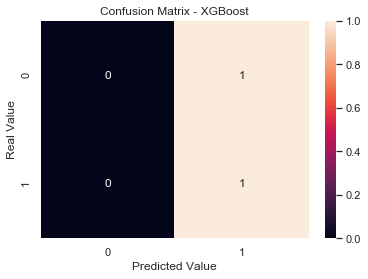

In [85]:
# final XGBoost model
xgb = XGBClassifier(max_depth=1, learning_rate=0.1, n_estimators=50, gamma=5, min_child_weight=1)

xgb.fit(X_train, y_train)

# prediction
X_test_xgb = scaler.transform(X_test)
y_pred_xgb = xgb.predict(X_test_xgb)

# classification report
print(classification_report(y_test, y_pred_xgb))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_xgb, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix - XGBoost')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()

#### значимость признаков

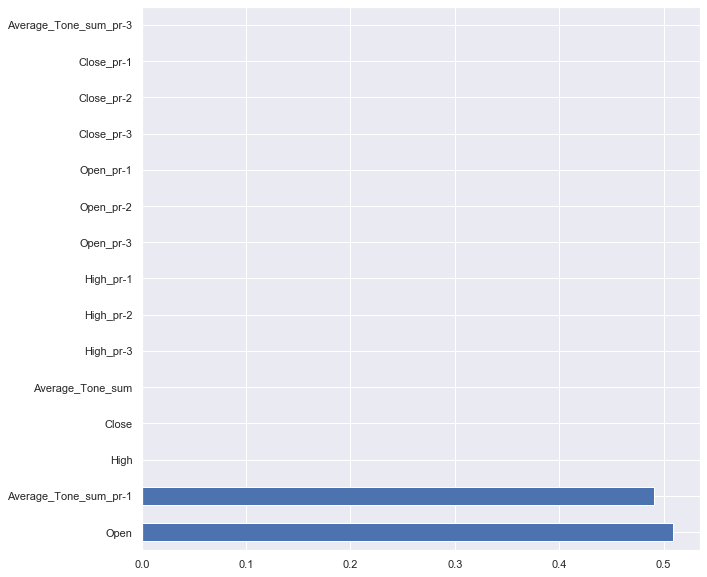

In [86]:
#есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(xgb.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       109
           1       0.57      1.00      0.73       144

    accuracy                           0.57       253
   macro avg       0.28      0.50      0.36       253
weighted avg       0.32      0.57      0.41       253



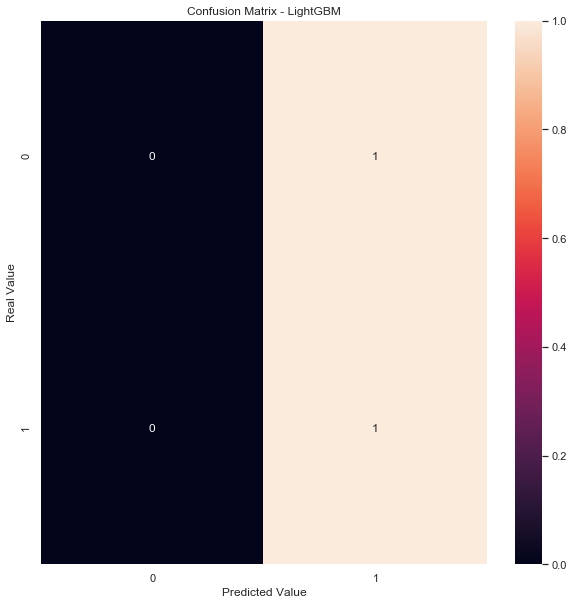

In [87]:
# final LightGBM model
lgb = LGBMClassifier(num_leaves=20, max_depth=5, learning_rate=0.001, min_data_in_leaf=100)

lgb.fit(X_train, y_train)

# prediction
X_test_lgb = scaler.transform(X_test)
y_pred_lgb = lgb.predict(X_test_lgb)

# classification report
print(classification_report(y_test, y_pred_lgb))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_lgb, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix - LightGBM')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()

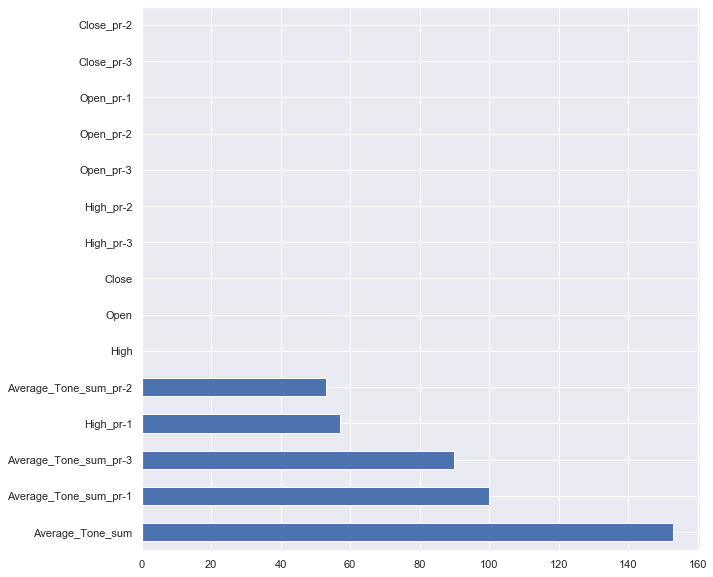

In [88]:
#есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(lgb.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

              precision    recall  f1-score   support

           0       0.54      0.59      0.56       109
           1       0.66      0.62      0.64       144

    accuracy                           0.60       253
   macro avg       0.60      0.60      0.60       253
weighted avg       0.61      0.60      0.61       253



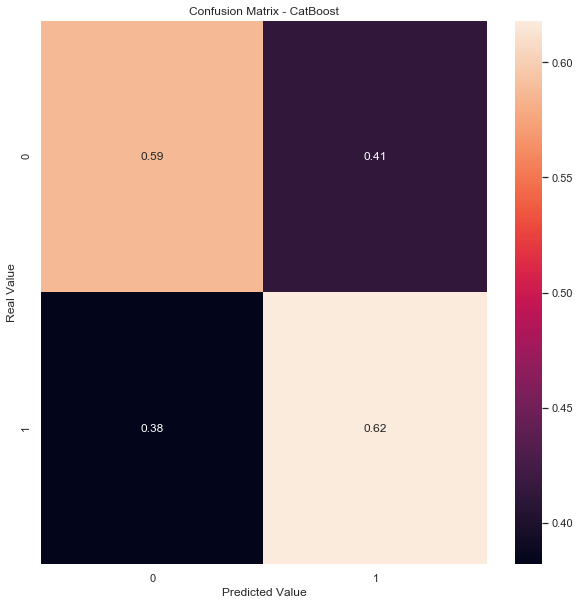

In [89]:
# final CatBoost model
cb = CatBoostClassifier(learning_rate=0.03, depth=8, l2_leaf_reg=10, logging_level='Silent')

cb.fit(X_train, y_train)

# prediction
X_test_cb = scaler.transform(X_test)
y_pred_cb = cb.predict(X_test_cb)

# classification report
print(classification_report(y_test, y_pred_cb))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_cb, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix - CatBoost')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()

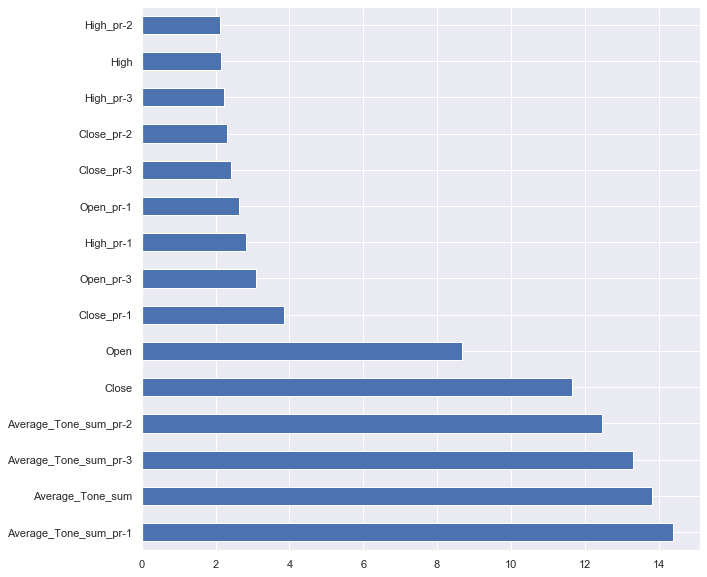

In [90]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(cb.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')